# 🎬 **Movies Reviews- Sentiment Analysis**

<div style="border: 4px solid #66b3ff; border-radius: 10px; padding: 10px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">
The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.</div>

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:

%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')


In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
print("Number of duplicated values:", df_reviews['review'].duplicated().sum())

Number of duplicated values: 91


In [7]:
# Remove duplicated values in 'review' column
df_reviews.drop_duplicates(subset='review', inplace=True)

## **🧐 Exploratory Data Analysis**

<div style="border: 4px solid #66b3ff; border-radius: 10px; padding: 10px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">
➡️ Let's check the number of movies and reviews over years.
</div>

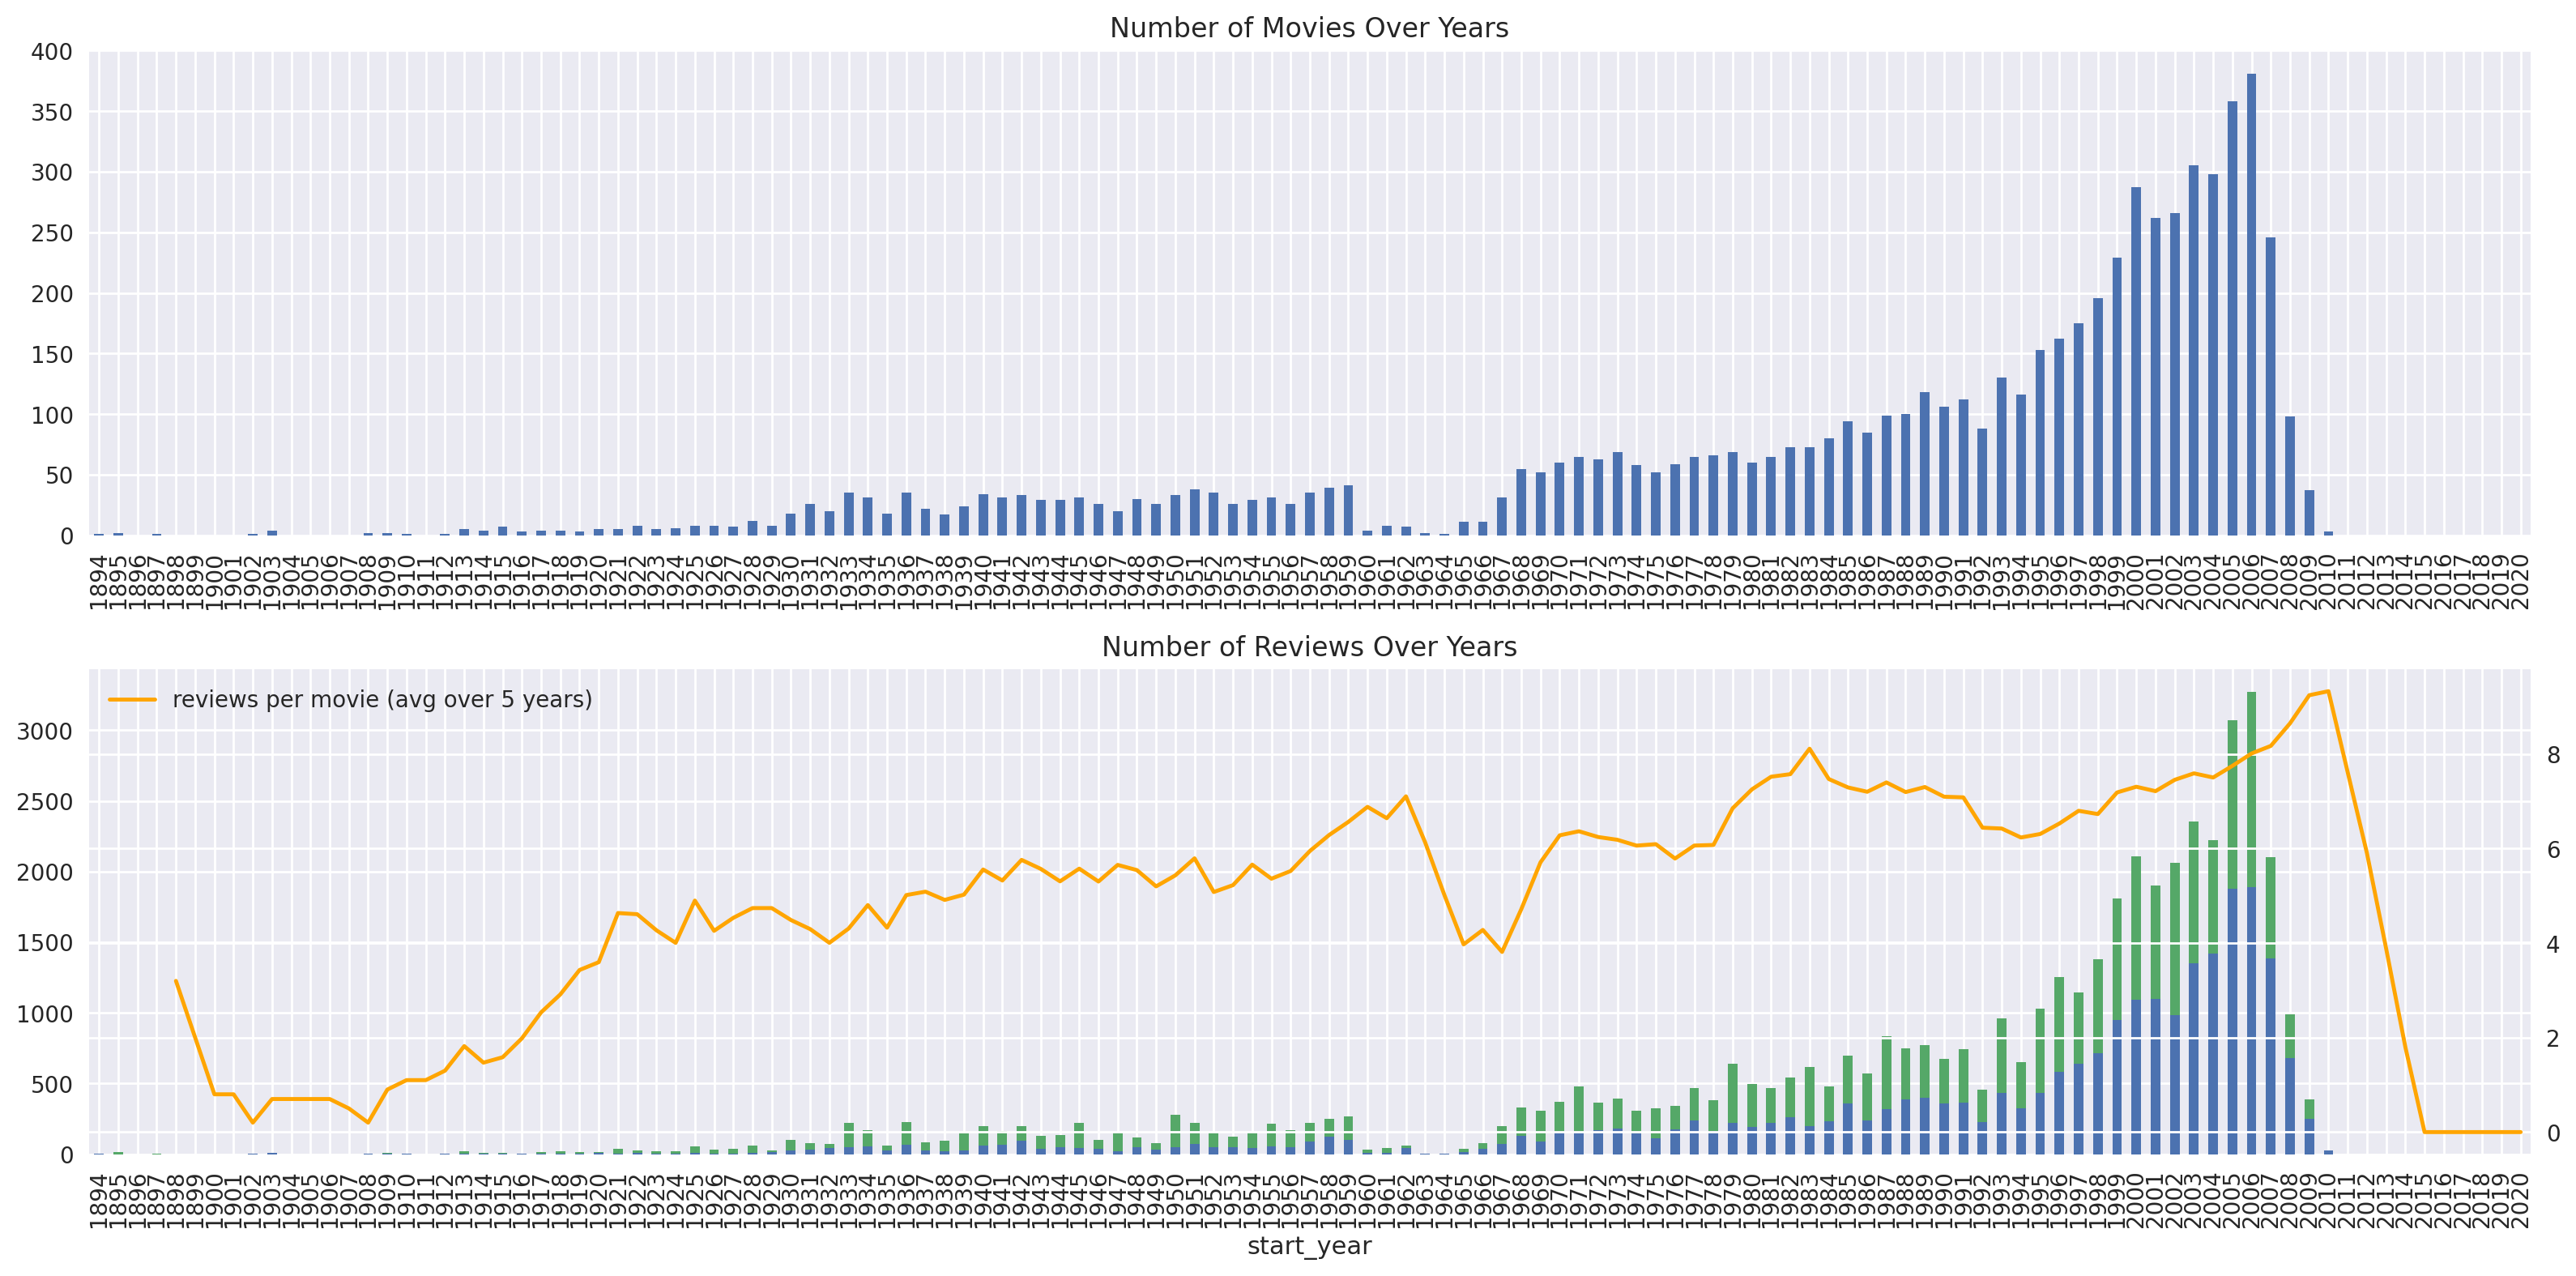

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

These plots illustrate the trends of movie production and review submissions over the years:

*   **Number of Movies Over Years:** The top bar chart shows the count of unique movies released each year. This helps in understanding the historical movie production volume and identifying periods of high or low output.
*   **Number of Reviews Over Years:** The bottom stacked bar chart displays the total number of reviews per year, further broken down by positive (green) and negative (blue) polarities. The orange line on the secondary y-axis represents the 5-year rolling average of reviews per movie, indicating how review engagement has changed relative to the number of movies released.

</div>

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

➡️ Let's check the **distribution of number of reviews per movie** with the exact counting and KDE (just to learn how it may differ from the exact counting)
</div>

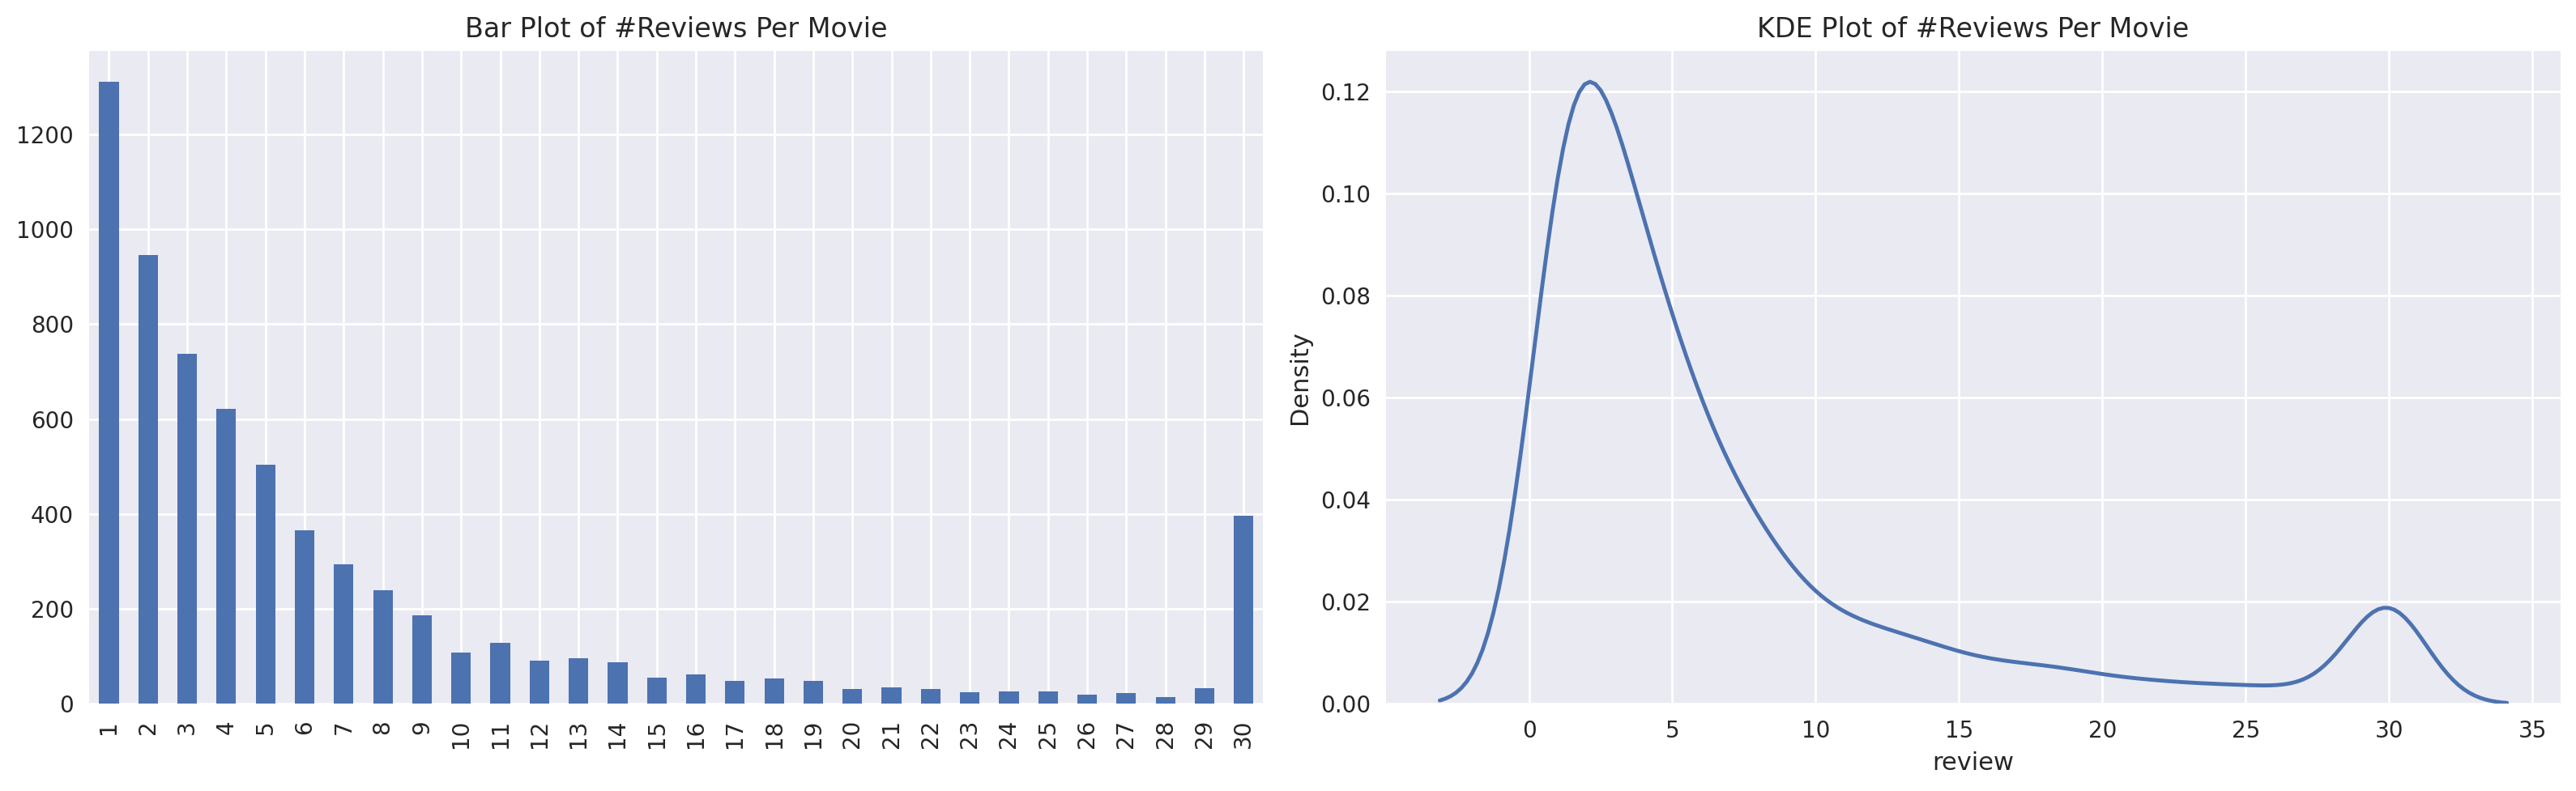

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

These plots illustrate the distribution of the number of reviews each movie has received:

*   **Bar Plot of #Reviews Per Movie:** This bar chart shows the exact count of movies that received a specific number of reviews.Most movies receive few reviews (less than 10). It is noticeable than around 400 movies receive 30 reviews.  
*   **KDE Plot of #Reviews Per Movie:** This Kernel Density Estimate (KDE) plot provides a smoothed, continuous representation of the same distribution. It helps to visualize the overall shape of the distribution, highlighting where the majority of movies fall in terms of review count and identifying a peaks around 30 reviews.

</div>

In [10]:
df_reviews['pos'].value_counts(normalize=True)*100

0    50.127011
1    49.872989
Name: pos, dtype: float64

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;
border-radius:6px;margin:12px 0;">

➡️ The classes are balanced with ~50% of the values in each category.

</div>

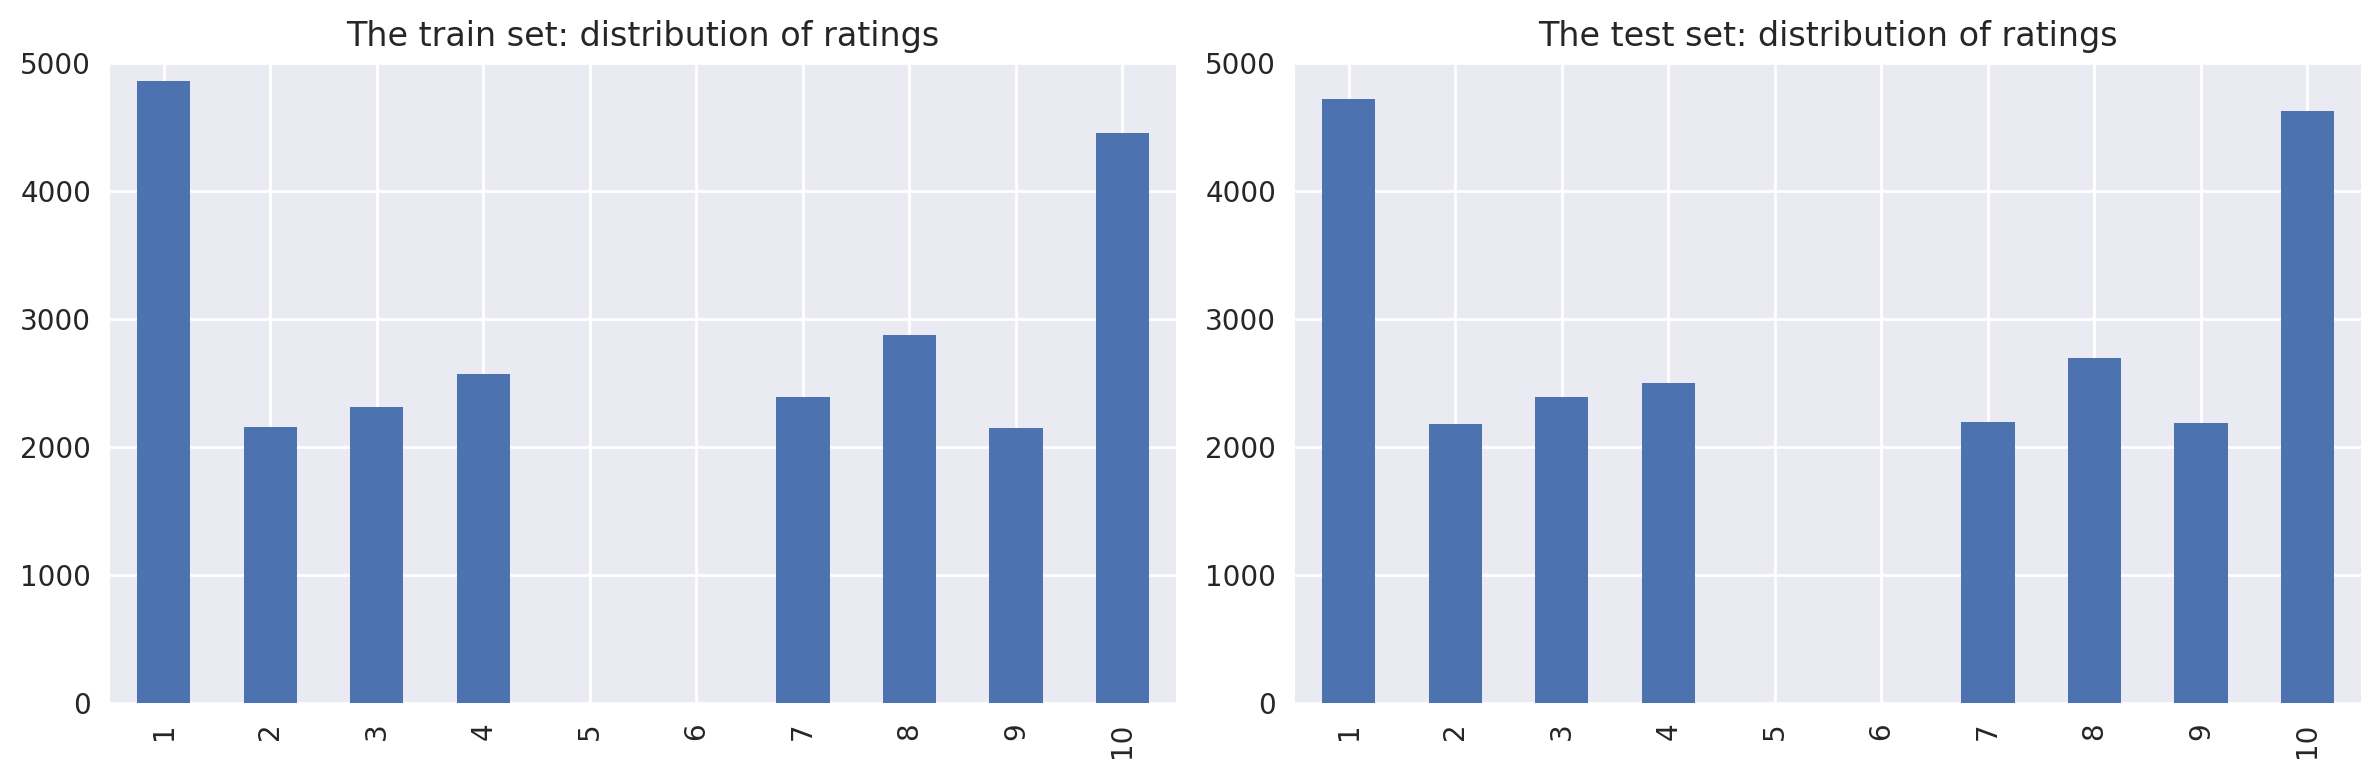

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

These plots show the distribution of movie ratings in the dataset:

*   **The train set: distribution of ratings:** This bar chart displays the frequency of each rating (from 1 to 10) within the training dataset. From the chart, we can infere that extreme values (1 or 0) are more frequent than medium values.
*   **The test set: distribution of ratings:** Similarly, this bar chart shows the frequency of each rating within the test dataset. We can see that both sets have a similar representation of ratings, which is crucial for evaluating model generalization.

</div>

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

➡️ Let's check the **distribution of negative and positive reviews over the years for two parts of the dataset**. </div>

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


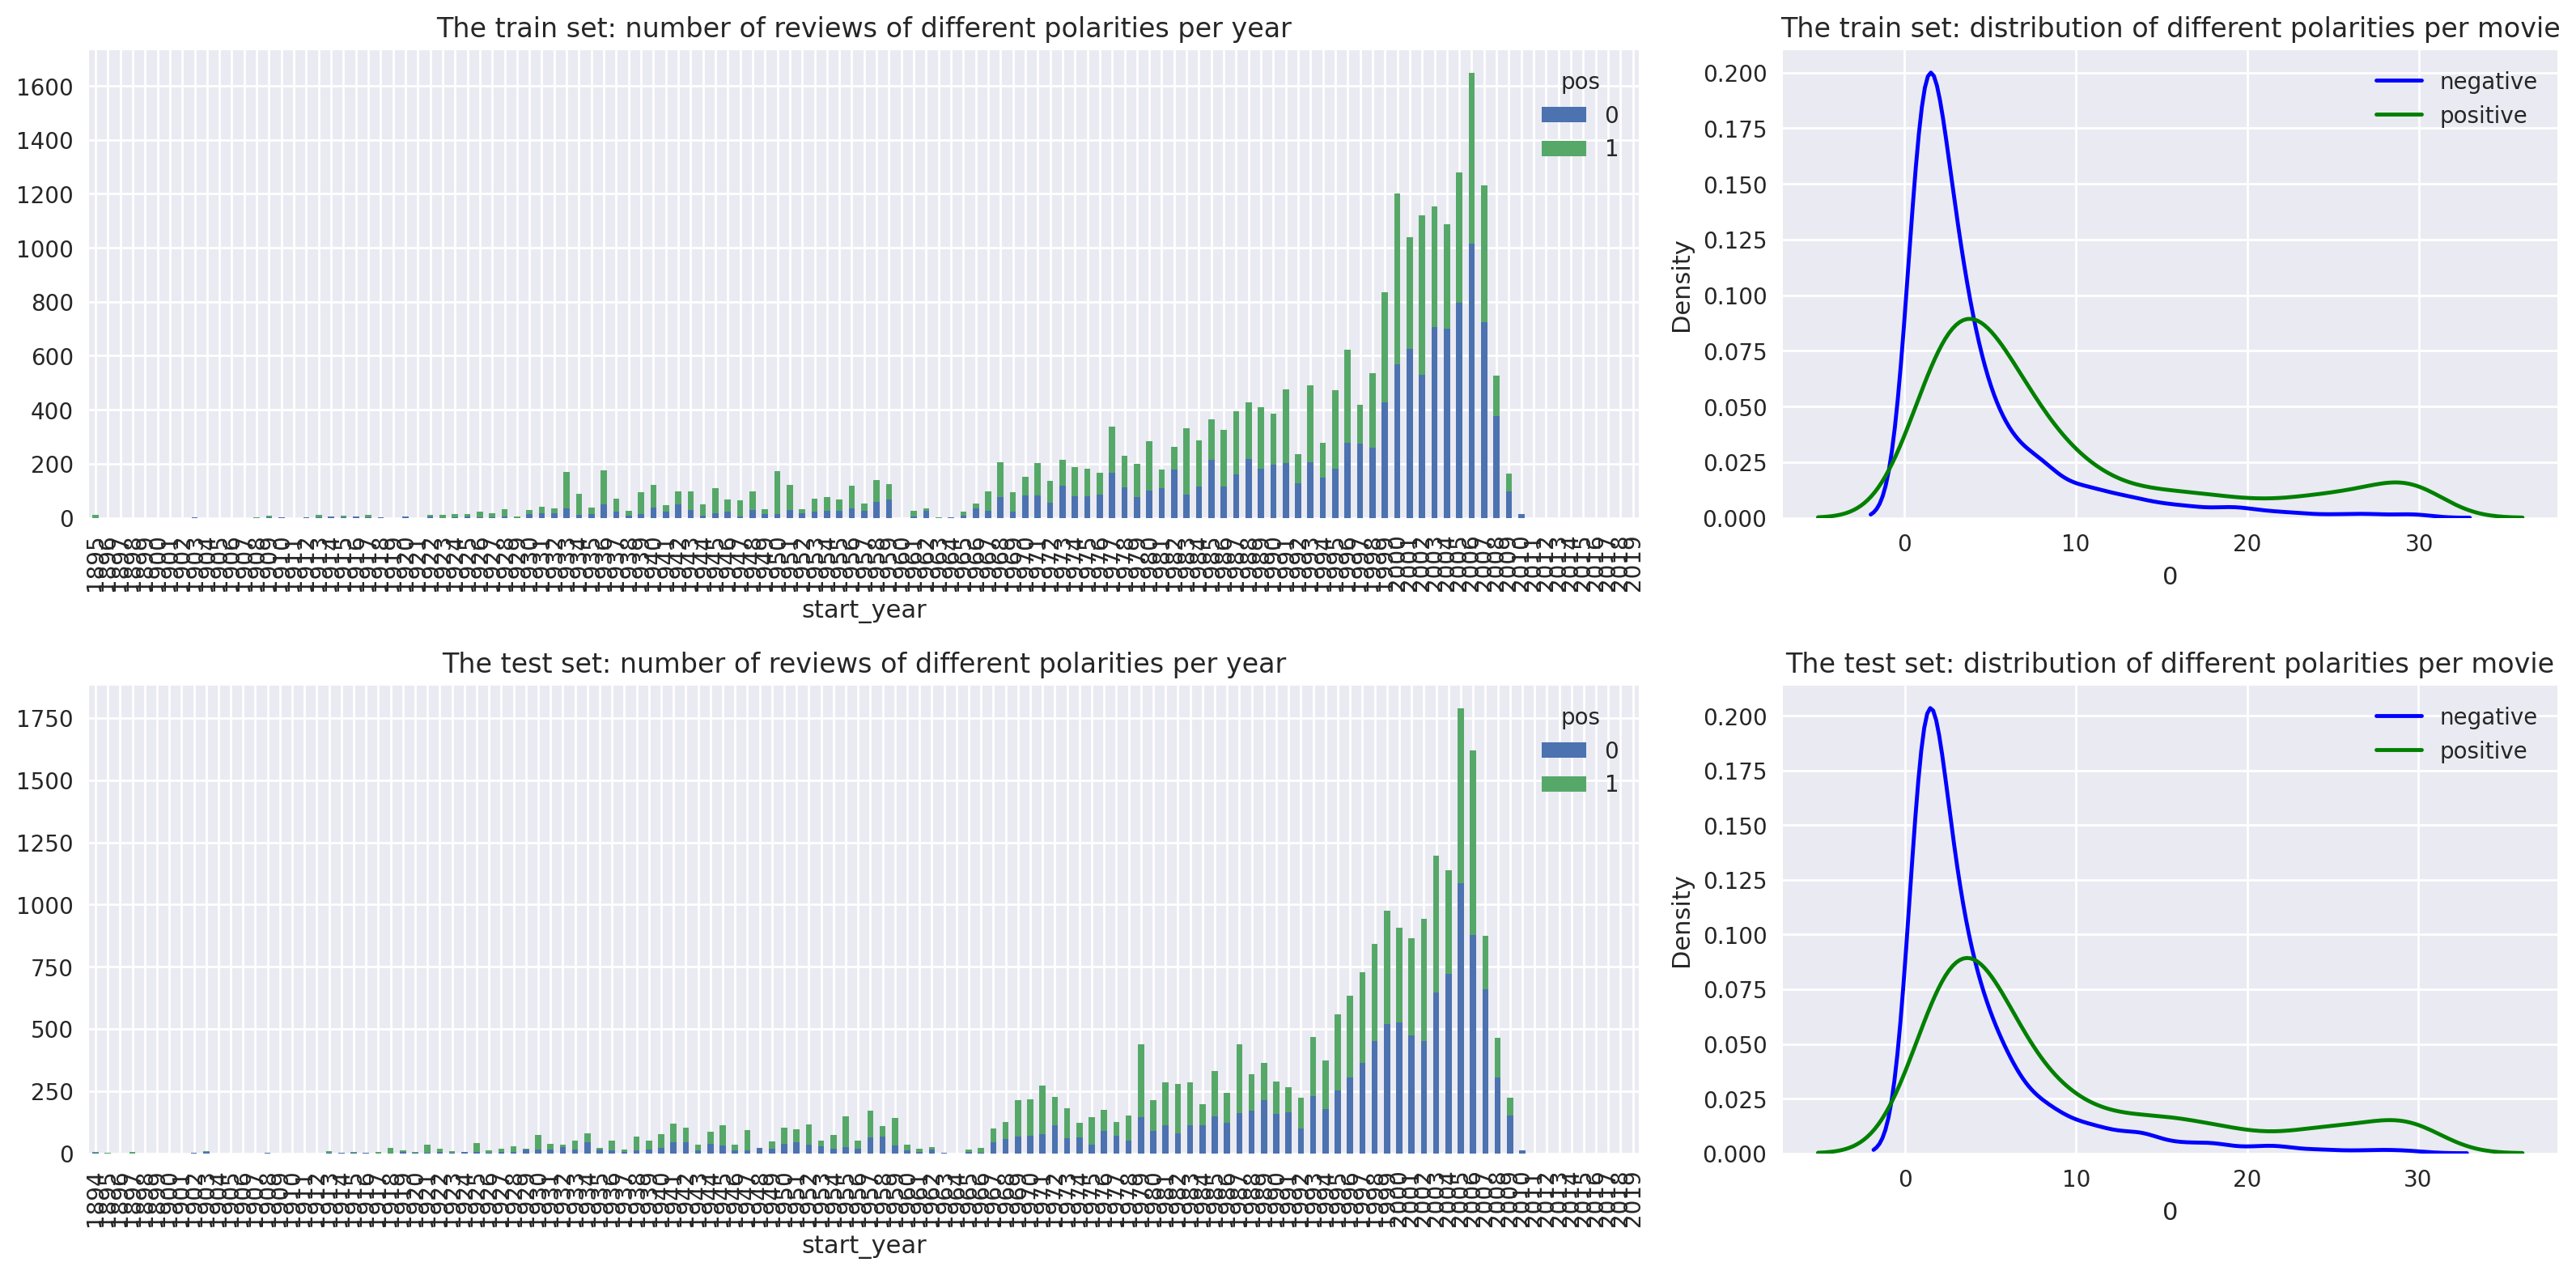

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

These plots show the distribution of negative (blue) and positive (green) reviews:

*   **The train set: number of reviews of different polarities per year (top-left):** This stacked bar chart displays the count of positive and negative reviews in the training dataset for each year, showing how review polarity has changed over time, with more number of reviews the last years.
*   **The train set: distribution of different polarities per movie (top-right):** This KDE plot illustrates the distribution of positive and negative reviews per movie within the training set, indicating how balanced the polarity is at a per-movie level.
*   **The test set: number of reviews of different polarities per year (bottom-left):** Similar to the top-left, this stacked bar chart shows the yearly distribution of positive and negative reviews in the test dataset.
*   **The test set: distribution of different polarities per movie (bottom-right):** Analogous to the top-right, this KDE plot reveals the distribution of positive and negative reviews per movie in the test dataset.
We can see that both sets have a similar representation of distribution of negative and positive reviews over the years.
</div>

## **🧪 Evaluation Procedure**

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

➡️  Composing an evaluation routine which can be used for all models in this project
</div>

In [13]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## **🔤 Normalization**

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

➡️  We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc. Let's normalize the text.
</div>

In [14]:
# Convert reviews into lowercase
df_reviews['review_norm'] = df_reviews['review'].str.lower()

# Eliminate digits, puntuactions marks, etc
import re
pattern= r"[^a-z]"
df_reviews['review_norm'] = df_reviews['review_norm'].apply(lambda x: re.sub(pattern," ",x))
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made   presenti...
2    there is no real story the film seems more lik...
3    um      a serious film about troubled teens in...
4    i m totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

## 🗂️ **Train / Test Split**

➡️ Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is ds_part.

In [15]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23757, 18)
(23483, 18)


## **🧠 Models**

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

➡️ Let's train six different models for the given train dataset and test them for the given test dataset:
  - `model_0`: constant
  - `model_1`: NLTK, TF-IDF and LR
  - `model_3`: spaCy, TF-IDF and LR
  - `model_4`: spaCy, TF-IDF and LGBMClassifier
  - `model_9`: BERT and LR
  - `model_10`: BERT and LGBMClassifier
</div>

In [16]:
RANDOM_STATE = 12345

### Model 0 - Constant

In [17]:
from sklearn.dummy import DummyClassifier

In [18]:
train_features_0 = df_reviews_train['review_norm']
test_features_0 = df_reviews_test['review_norm']

In [19]:
model_0 = DummyClassifier(strategy='constant', constant=1)
model_0.fit(train_features_0, train_target)

DummyClassifier(constant=1, strategy='constant')

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


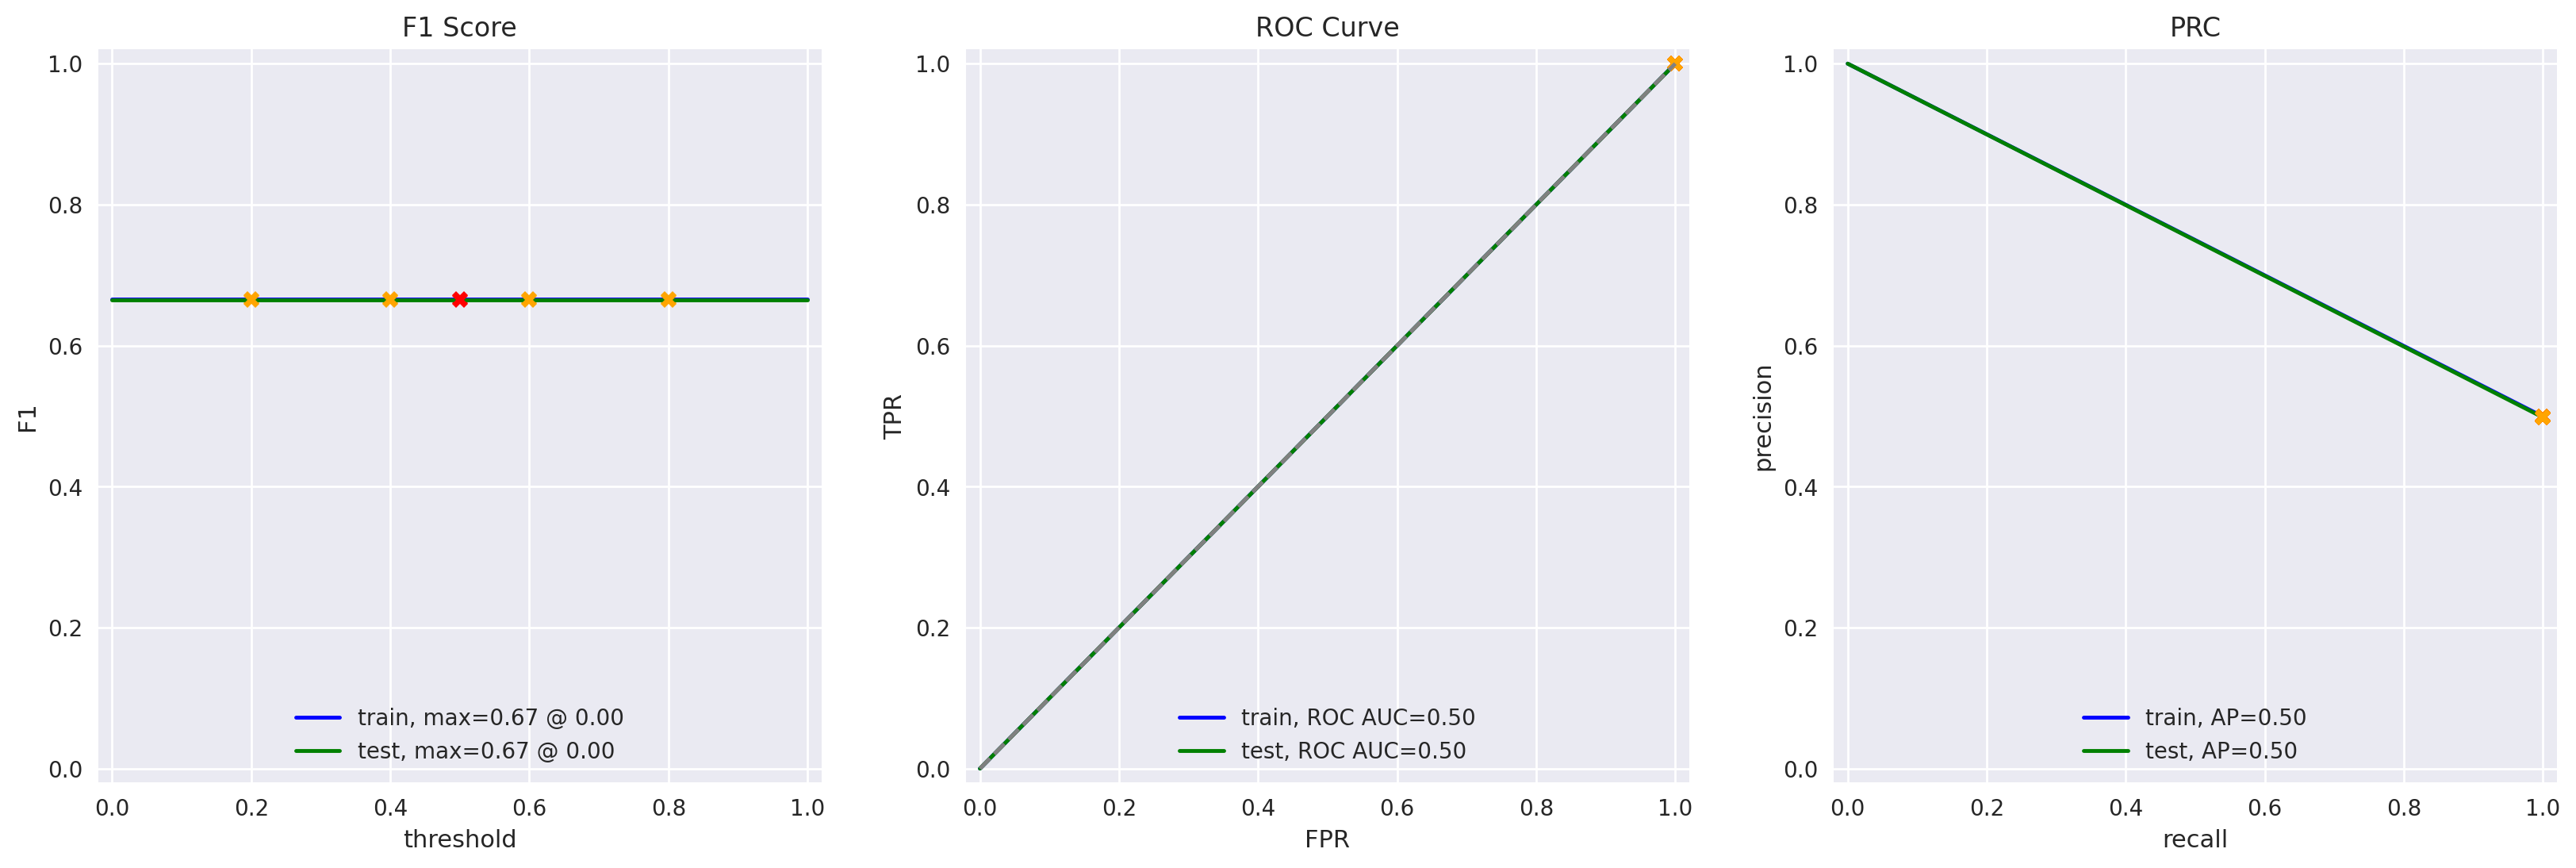

In [20]:
evaluate_model(model_0, train_features_0, train_target, test_features_0, test_target)

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

### 📝 Model_0: Constant Baseline Model Interpretation

| Metric | Score (Test Set) | Conclusion for Review Classification |
| :--- | :--- | :--- |
| **Accuracy** | 0.50 | Accuracy is **$\approx 50\%$**, meaning the model performs no better than a **random coin flip** when classifying reviews. |
| **F1 Score** | 0.67 | The high F1 score is a **consequence of the constant prediction** (and near-even class split), not true skill. |
| **APS** | 0.50 | The Average Precision Score is at the **baseline level**, indicating **no gain in precision** over a naive approach. |
| **ROC AUC** | 0.50 | The **ROC AUC of 0.50** confirms this model has **zero discriminative power**, failing to distinguish between positive and negative reviews. |

</div>

### Model 1 - NLTK, TF-IDF and LR

In [21]:

import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords


In [22]:
# Declare features for model 1
train_features_1 = df_reviews_train['review_norm']
test_features_1 = df_reviews_test['review_norm']

In [23]:
# Tokenize and lemmatize the reviews
lemmatizer  = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    doc=word_tokenize(text)
    lemmas = []
    for token in doc:
        lemmas.append(lemmatizer.lemmatize(token))
    return ' '.join(lemmas)

train_features_1_processed = train_features_1.apply(tokenize_and_lemmatize)
test_features_1_processed = test_features_1.apply(tokenize_and_lemmatize)

In [24]:
# Vectorize with TfidfVectorizer feature
stop_words = stopwords.words('english')

tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)
train_features_1_tfidf = tfidf_vectorizer_1.fit_transform(train_features_1_processed)
test_features_1_tfidf = tfidf_vectorizer_1.transform(test_features_1_processed)

print("Shape of train_features_1_tfidf:", train_features_1_tfidf.shape)
print("Shape of test_features_1_tfidf:", test_features_1_tfidf.shape)

Shape of train_features_1_tfidf: (23757, 64015)
Shape of test_features_1_tfidf: (23483, 64015)


In [25]:
# Train a Logistic Regression
model_1 = LogisticRegression(random_state=RANDOM_STATE)
model_1.fit(train_features_1_tfidf, train_target)

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


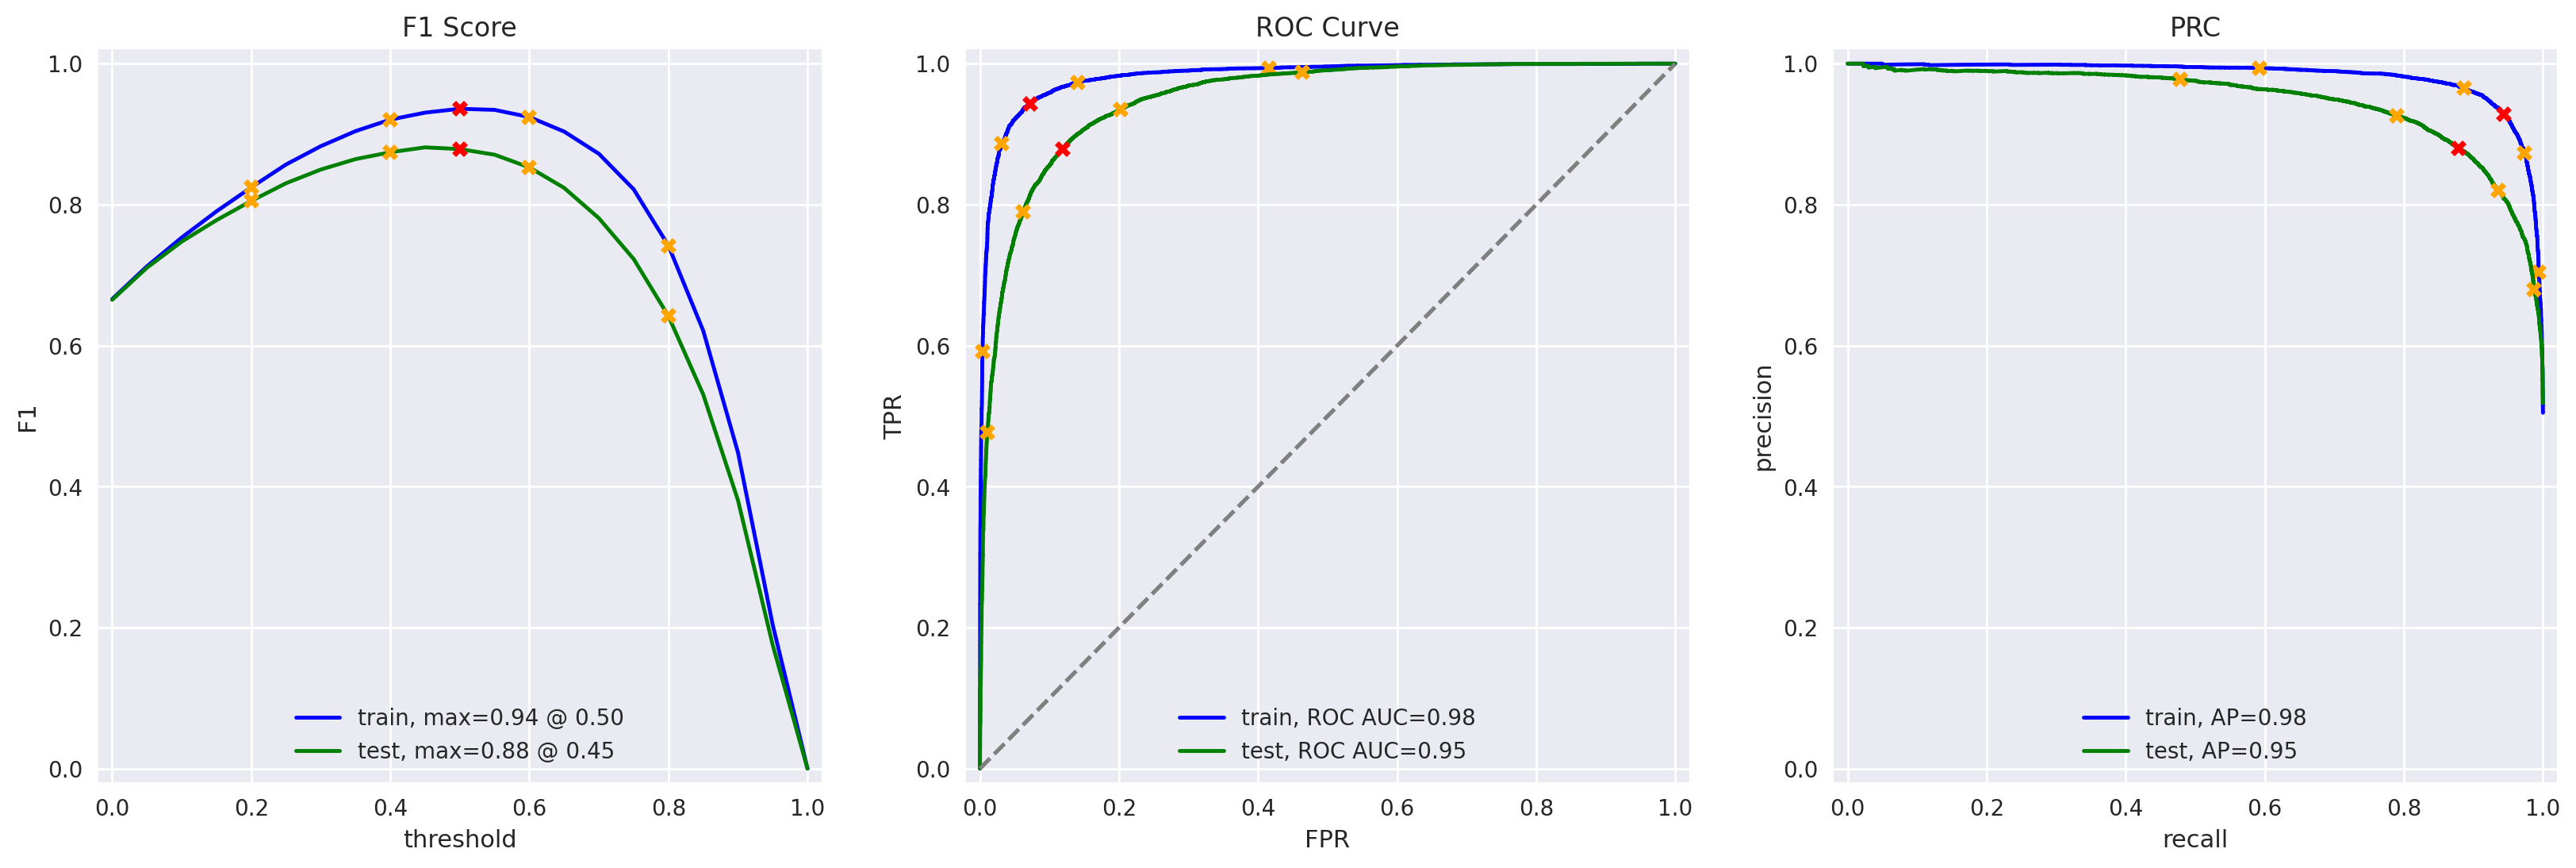

In [26]:
evaluate_model(model_1, train_features_1_tfidf, train_target, test_features_1_tfidf, test_target)


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

### 📝 Model_1: Logistic Regression (TF-IDF + NLTK) Interpretation

| Metric | Score (Test Set) | Conclusion for Review Classification |
| :--- | :--- | :--- |
| **Accuracy** | **0.88** | Accuracy is **$88\%$**, a massive improvement over the baseline, indicating the model has significant **predictive power**. |
| **F1 Score** | **0.88** | The high F1 Score confirms the model balances **precision and recall** effectively, unlike the constant model. |
| **APS** | **0.95** | An Average Precision Score of **0.95** indicates the model maintains **high precision** across different confidence thresholds. |
| **ROC AUC** | **0.95** | The **ROC AUC of 0.95** demonstrates **excellent discriminative power**, successfully distinguishing between positive and negative reviews. |

</div>

### Model 3 - spaCy, TF-IDF and LR

In [27]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [28]:
# Declare features for model 3
train_features_3 = df_reviews_train['review_norm']
test_features_3 = df_reviews_test['review_norm']

In [29]:

# Tokenize and lemmatize the reviews

doc=[]
def text_preprocessing_3(text):
    doc = nlp(text)
    tokens =[]
    tokens = [token.lemma_ for token in doc if not token.is_stop]

    return ' '.join(tokens)
    
train_features_3_processed = train_features_3.progress_apply(text_preprocessing_3)
test_features_3_processed = test_features_3.progress_apply(text_preprocessing_3)


  0%|          | 0/23757 [00:00<?, ?it/s]

  0%|          | 0/23483 [00:00<?, ?it/s]

In [30]:
# Vectorize with TfidfVectorizer
stop_words = stopwords.words('english')

tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)
train_features_3_tfidf = tfidf_vectorizer_3.fit_transform(train_features_3_processed)
test_features_3_tfidf = tfidf_vectorizer_3.transform(test_features_3_processed)

print("Shape of train_features_3_tfidf:", train_features_3_tfidf.shape)
print("Shape of test_features_3_tfidf:", test_features_3_tfidf.shape)

Shape of train_features_3_tfidf: (23757, 59274)
Shape of test_features_3_tfidf: (23483, 59274)


In [31]:
# Train a Logistic Regression
model_3 = LogisticRegression(random_state=RANDOM_STATE)
model_3.fit(train_features_3_tfidf, train_target)

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


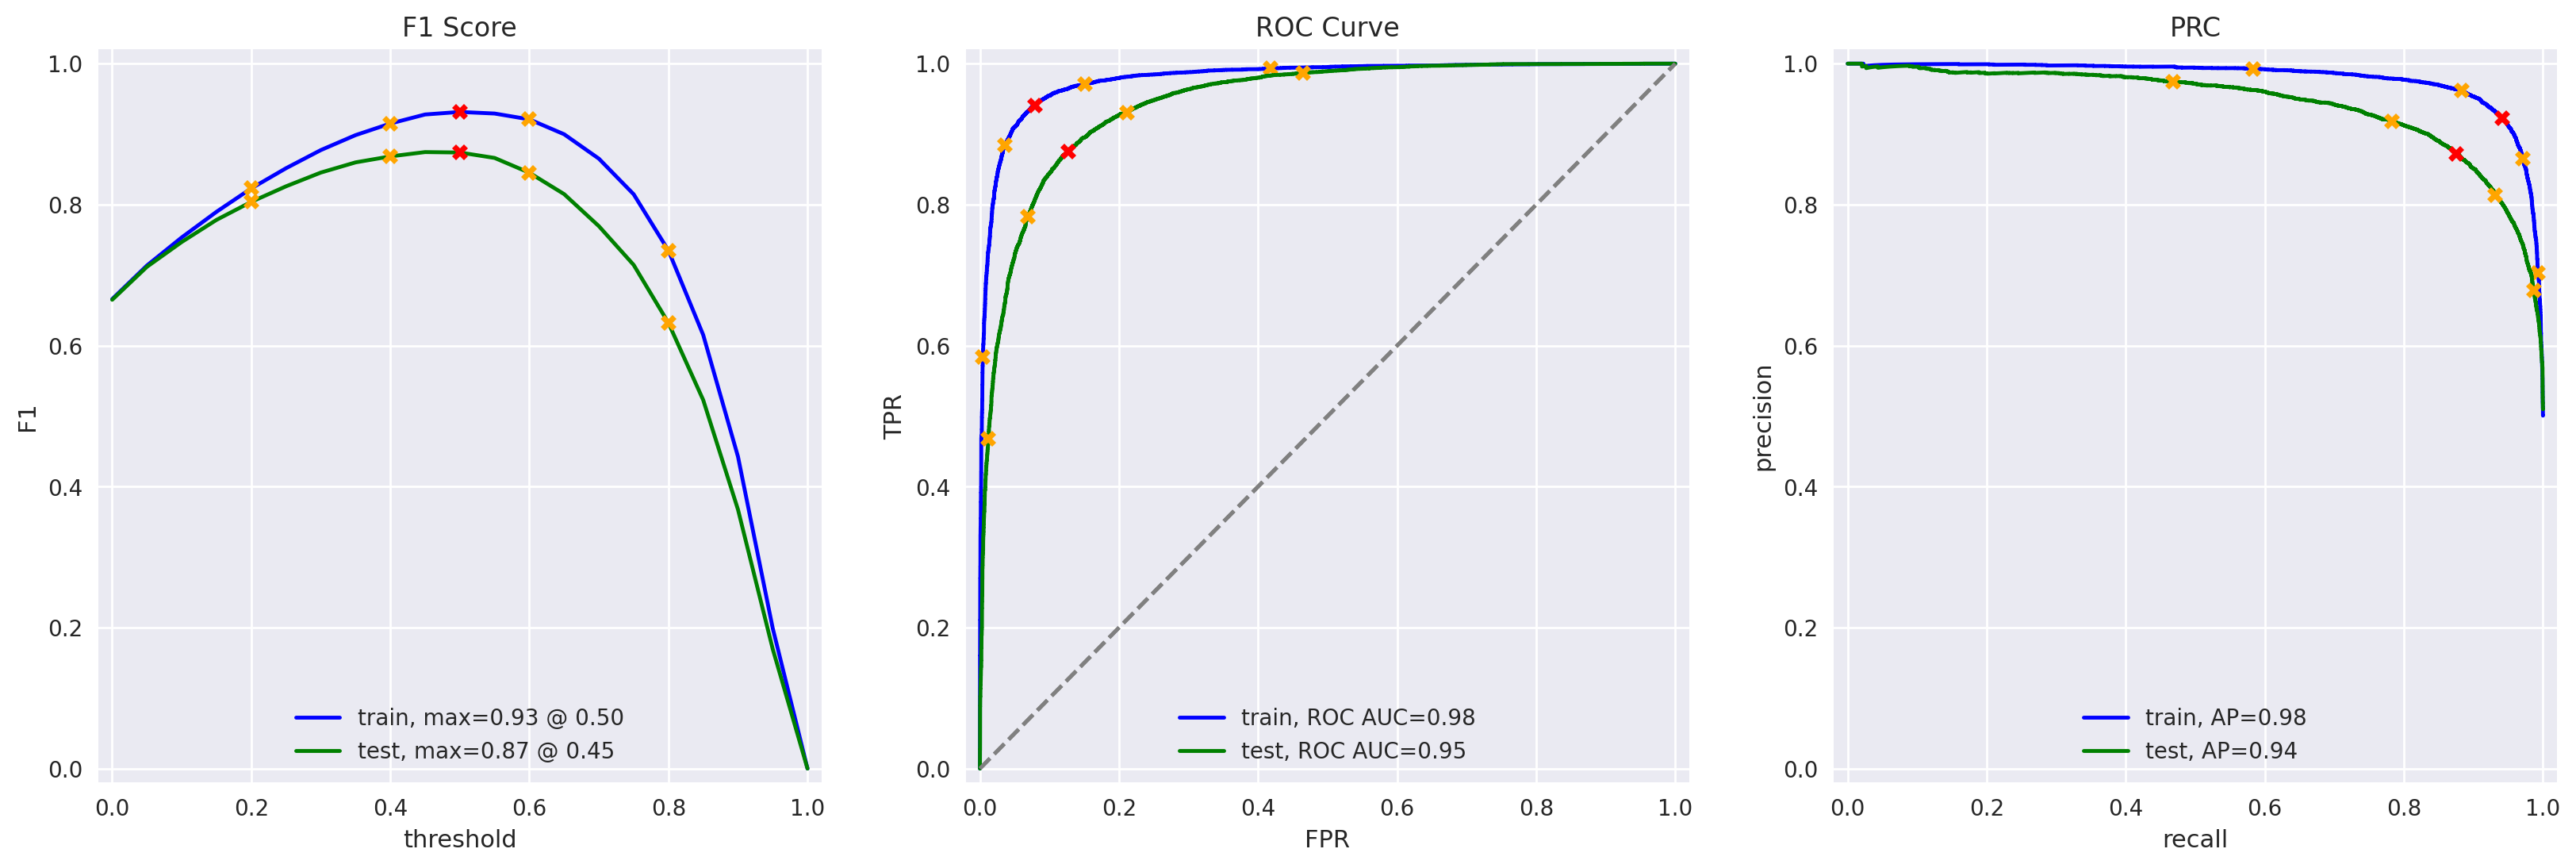

In [32]:

# Evaluate the model
evaluate_model(model_3, train_features_3_tfidf, train_target, test_features_3_tfidf, test_target)

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

### 📝 Model_3: Logistic Regression (TF-IDF + spaCy) Interpretation

| Metric | Score (Test Set) | Conclusion for Review Classification |
| :--- | :--- | :--- |
| **Accuracy** | **0.87** | Accuracy is **$87\%$**, remaining very strong and comparable to the NLTK model, proving the robustness of the Logistic Regression approach. |
| **F1 Score** | **0.87** | A high F1 score indicates the model continues to handle **precision and recall** well, effectively identifying positive and negative reviews. |
| **APS** | **0.94** | The Average Precision Score of **0.94** is excellent, showing the model assigns high probabilities to positive samples with high consistency. |
| **ROC AUC** | **0.95** | The **ROC AUC of 0.95** is identical to the previous model, confirming **excellent discriminative power** regardless of the tokenizer used (spaCy vs NLTK). |

</div>

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [33]:
from lightgbm import LGBMClassifier

In [34]:
# Declare features for model 4 (we can use the same as in model_3)

train_features_4_tfidf = train_features_3_tfidf
test_features_4_tfidf = test_features_3_tfidf

In [35]:
# Train the LGBMClassifier
model_4 = LGBMClassifier(random_state=RANDOM_STATE, max_depth=5, num_leaves=40, n_estimators=300)
model_4.fit(train_features_4_tfidf, train_target)

LGBMClassifier(max_depth=5, n_estimators=300, num_leaves=40, random_state=12345)

          train  test
Accuracy   0.92  0.85
F1         0.92  0.85
APS        0.98  0.93
ROC AUC    0.98  0.93


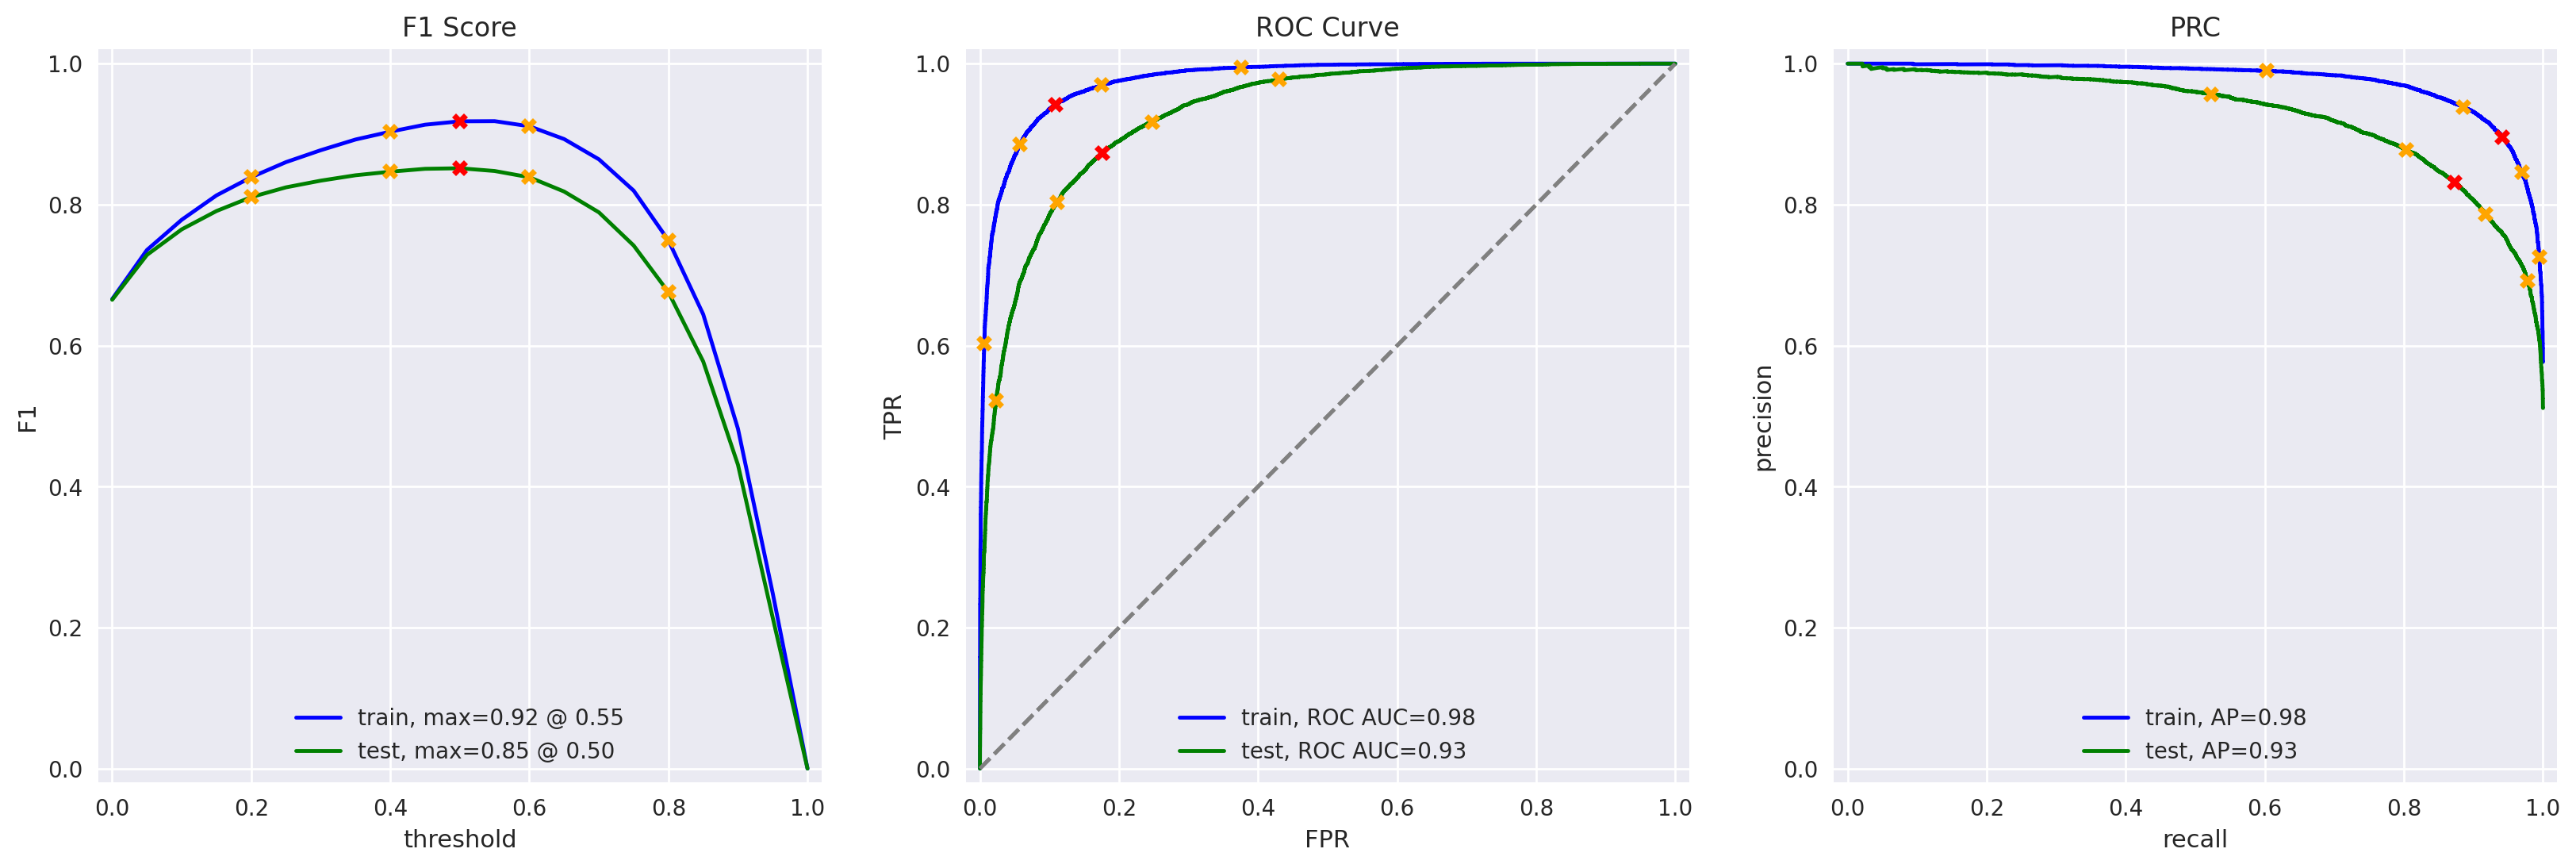

In [36]:
# Evaluate the model
evaluate_model(model_4, train_features_4_tfidf, train_target, test_features_4_tfidf, test_target)

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

### 📝 Model_4: LGBMClassifier (TF-IDF + spaCy) Interpretation

| Metric | Score (Test Set) | Conclusion for Review Classification |
| :--- | :--- | :--- |
| **Accuracy** | **0.85** | Accuracy is **$85\%$**, which is a strong result, though slightly lower than the Logistic Regression models ($87-88\%$), likely due to tree-based models struggling slightly more with high-dimensional sparse data (TF-IDF), with some manual tuning. Further advanced tuning may improve metrics.|
| **F1 Score** | **0.85** | The F1 Score of **0.85** indicates the model still maintains a good balance between **precision and recall**, effectively classifying the majority of reviews. |
| **APS** | **0.93** | The Average Precision Score remains very high at **0.93**, showing the model is reliable at ranking positive reviews correctly at the top of the list. |
| **ROC AUC** | **0.93** | The **ROC AUC of 0.94** confirms strong **discriminative power**, though it performs slightly below the linear models (0.95) in distinguishing between positive and negative classes. |

</div>

###  Model 9 - BERT and LR

In [37]:
import torch
import transformers

In [38]:
# Declare features for model 9
train_features_9 = df_reviews_train['review_norm']
test_features_9 = df_reviews_test['review_norm']

In [39]:
MAX_TEXT_SAMPLE = 200

In [40]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    # preprocessing
    ids_list = []
    attention_mask_list = []

    # Process ALL texts passed to the function (control the size outside)
    max_length = 512
    for input_text in texts:
      ids = tokenizer.encode(
          input_text.lower(),
          add_special_tokens=True,
          truncation=True,
          max_length=max_length,
      )
      padded = np.array(ids + [0] * (max_length - len(ids)))
      attention_mask = np.where(padded != 0, 1, 0)
      ids_list.append(padded)
      attention_mask_list.append(attention_mask)

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')

    # gettings embeddings in batches
    batch_size = 25  # typically the batch size is equal to 100 but we can set it to lower values to lower the memory requirements
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # The attention_mask_batch should remain a torch.LongTensor and not be converted to numpy
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [42]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
print(f"Generating embeddings for first {MAX_TEXT_SAMPLE} samples only")

train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'][:MAX_TEXT_SAMPLE])
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'][:MAX_TEXT_SAMPLE])


Generating embeddings for first 200 samples only
Using the cpu device.


  0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipykernel_89/3608380931.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


Using the cpu device.


  0%|          | 0/8 [00:00<?, ?it/s]

In [43]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(test_features_9.shape)
print(train_target.shape)

(23757,)
(200, 768)
(200, 768)
(23757,)


In [44]:
# Save embeddings
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

In [45]:
# Load embeddings

with np.load('features_9.npz') as data:
  train_features_9 = data['train_features_9']
  test_features_9 = data['test_features_9']


In [46]:
# Train a Logistic Regression
model_9 = LogisticRegression(random_state=RANDOM_STATE,solver='liblinear')
model_9.fit(train_features_9, train_target[:MAX_TEXT_SAMPLE])


LogisticRegression(random_state=12345, solver='liblinear')

          train  test
Accuracy    1.0  0.80
F1          1.0  0.78
APS         1.0  0.93
ROC AUC     1.0  0.90


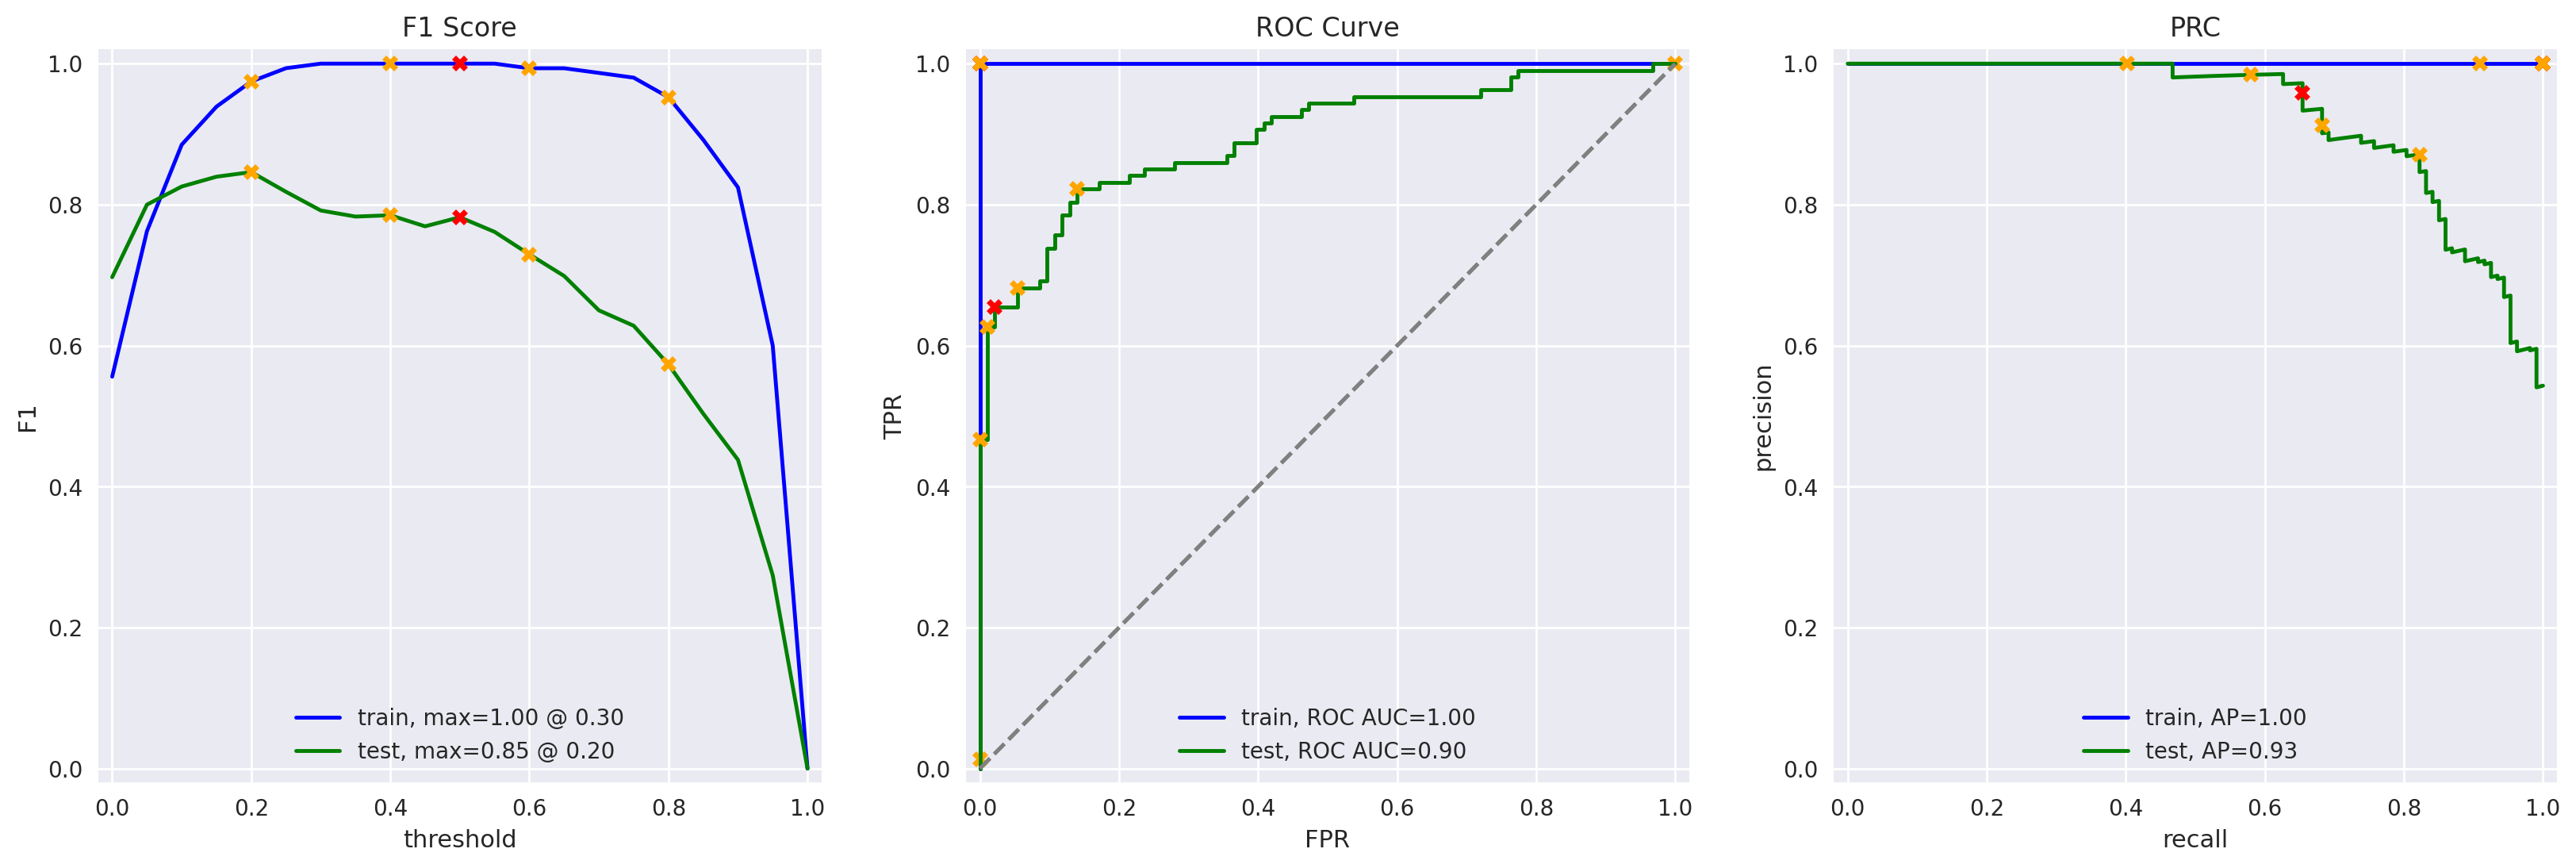

In [47]:
# Evaluate the model
evaluate_model(model_9, train_features_9, train_target[:MAX_TEXT_SAMPLE], test_features_9, test_target[:MAX_TEXT_SAMPLE])


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

### 📝 Model_9: Logistic Regression (BERT Features - 200 Samples)
| Metric | Score (Test Set) | Conclusion for Review Classification |
| :--- | :--- | :--- |
| **Accuracy** | **0.80** | Accuracy is **$80\%$**. While respectable, it is significantly lower than the TF-IDF models ($\approx 88\%$). This is the direct result of training on only **200 samples**. |
| **Overfitting** | **Gap: 0.20** | **Critical Observation:** The model achieved **perfect scores (1.0)** on training but dropped to **0.80** on test. This huge gap indicates **severe overfitting**—the model "memorized" the small training set rather than learning general patterns. |
| **APS & ROC** | **0.93 / 0.90** | Despite the overfitting, the **ROC AUC of 0.90** and **APS of 0.93** are surprisingly high. This demonstrates the **power of BERT embeddings**: even with very little data, the pre-trained representations provide excellent distinctiveness between classes. |
| **F1 Score** | **0.78** | The lower F1 score suggests the model struggles more with the precision/recall balance compared to the full-dataset models, likely making more specific errors due to the lack of diverse training examples. |

</div>

###  Model 10 - BERT and LGBMClassifier

In [48]:

train_features_10 = train_features_9
test_features_10 = test_features_9


In [49]:
# Train the LGBMClassifier
model_10 = LGBMClassifier(random_state=RANDOM_STATE, max_depth=5, num_leaves=40, n_estimators=300)
model_10.fit(train_features_10, train_target[:MAX_TEXT_SAMPLE])


LGBMClassifier(max_depth=5, n_estimators=300, num_leaves=40, random_state=12345)

          train  test
Accuracy    1.0  0.74
F1          1.0  0.70
APS         1.0  0.86
ROC AUC     1.0  0.85


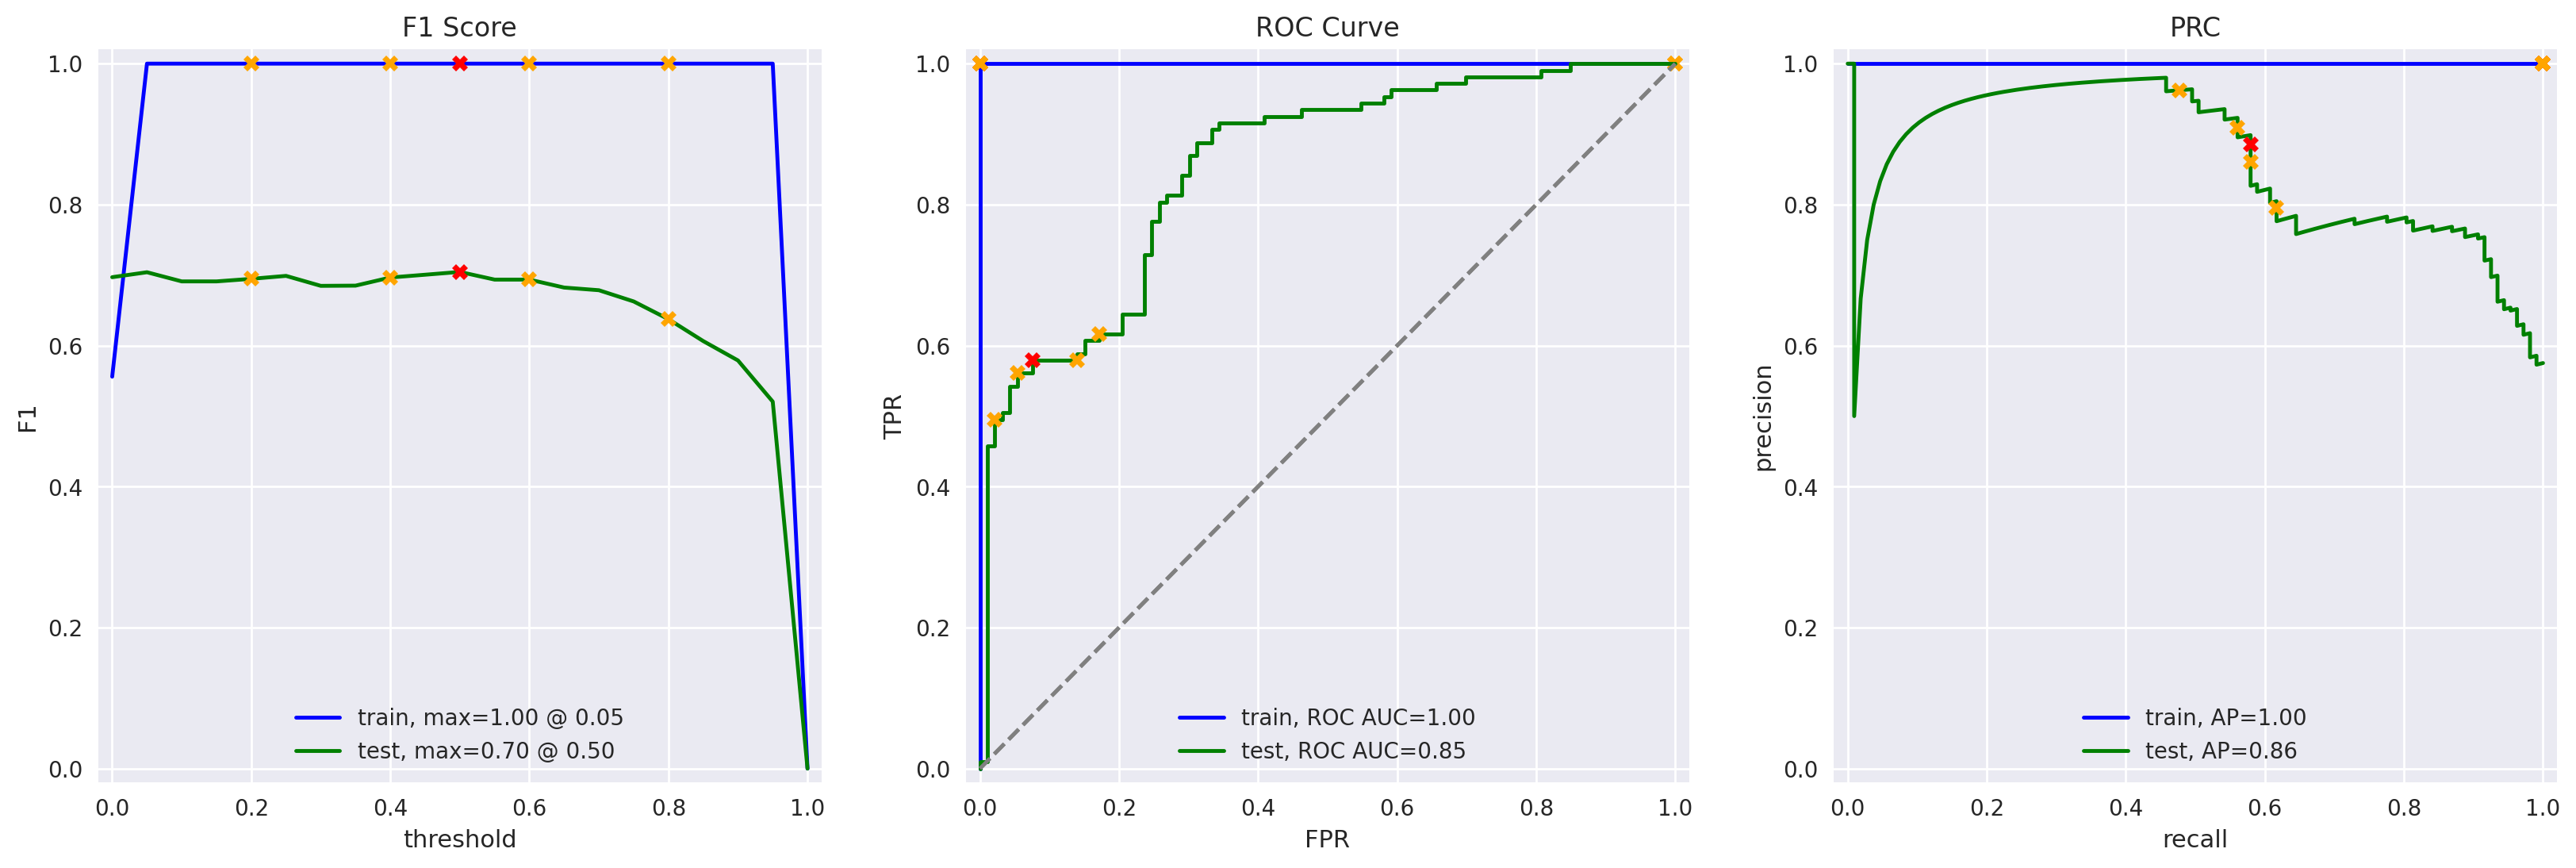

In [50]:
# Evaluate the model
evaluate_model(model_10, train_features_10, train_target[:MAX_TEXT_SAMPLE], test_features_10, test_target[:MAX_TEXT_SAMPLE])

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

### 📝 Model_10: LGBMClassifier (BERT Features - 200 Samples)

| Metric | Score (Test Set) | Conclusion for Review Classification |
| :--- | :--- | :--- |
| **Accuracy** | **0.70** | Accuracy is **74%**. While functional, performance is heavily constrained by the sample size (**200 samples**). Gradient Boosting models typically require more data to establish robust decision boundaries. |
| **Overfitting** | **Gap: 0.26** | **Critical Observation:** The model achieved **perfect scores (1.0)** on training but dropped to **0.74** on test. This large gap confirms **severe overfitting**—the model effectively "memorized" the small training set rather than learning generalizable patterns. |
| **APS & ROC** | **0.86 / 0.85** | Despite the overfitting, the **ROC AUC (0.85)** and **APS (0.86)** remain strong. This demonstrates the robustness of **BERT embeddings**: the pre-trained representations provide excellent semantic separation, allowing for good ranking even when the classifier is data-starved. |
| **F1 Score** | **0.70** | The F1 score is the weakest metric, suggesting the model struggles with the Precision/Recall balance. Without more data, the model makes more specific errors in classification thresholds despite good probability ranking. |

</div>


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

### 🏆 Final Model Comparison & Selection

**Project Goal:** Classify positive/negative reviews with **F1 Score $\ge$ 0.85**.

| Model | Vectorizer | Algorithm | Test Accuracy | Test F1 Score | Status |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Model 0** | N/A | Constant (Dummy) | 0.50 | 0.67* | ❌ **Fail** (No Skill) |
| **Model 1** | TF-IDF (NLTK) | Logistic Regression | **0.88** | **0.88** | ✅ **PASS (Winner)** |
| **Model 3** | TF-IDF (spaCy) | Logistic Regression | 0.87 | 0.87 | ✅ **PASS** |
| **Model 4** | TF-IDF (spaCy) | LGBMClassifier | 0.85 | 0.85 | ✅ **PASS (Borderline)** |
| **Model 9** | BERT (Embeddings) | Logistic Regression | 0.80 | 0.78 | ❌ **Fail** (Insuff. Data) |
| **Model 10** | BERT (Embeddings) | LGBMClassifier | 0.74 | 0.70 | ❌ **Fail** (Insuff. Data) |

<br>

#### 🧠 Final Conclusions:
1.  **The Winner:** **Model_1 (NLTK + LogReg)** is the strongest candidate. It achieves the highest **Accuracy (0.88)** and **F1 Score (0.88)**, comfortably exceeding the project requirement.
2.  **NLTK vs. spaCy:** For this specific dataset, **NLTK proved to be the superior text processing library**, slightly outperforming spaCy (Model 1 vs Model 3).
3.  **Simplicity Wins:** Across both TF-IDF and BERT experiments, **Logistic Regression consistently outperformed LGBMClassifier**. This indicates that for this specific volume and type of data, the simpler linear approach generalized better than the complex boosting trees.
4.  **The BERT Limitation:** Both Model 9 and Model 10 failed to reach the threshold purely due to the **200-sample constraint**. However, Model 9 (LogReg) handled the data scarcity better (F1 0.78) than Model 10 (F1 0.70), which suffered from more severe overfitting. 

</div>

## ✍️ My Reviews

<div style="border: 2px solid #66b3ff; border-radius: 10px; padding: 12px; background-color: #f0f8ff; font-family: sans-serif; font-size: 12px0;">

➡️  Let's compose a few reviews, classify them with all the previous models and check for differences between the testing results of models.
We will predict the probabilities and apply the `evaluate_model` function that we build before. 
</div>

In [51]:
# Create new reviews for a new test sample

my_reviews = pd.DataFrame([
    "Terrible script and wooden acting. It felt like a cheap cash grab with no soul. Save your money and avoid this one at all costs.",
    "An absolute masterpiece. The cinematography was breathtaking and the acting was top-notch. I was on the edge of my seat the entire time.",
    "The pacing was all over the place. One minute it tries to be a serious drama, the next it’s a silly comedy. The tone is so inconsistent that it becomes unwatchable.",
    "A solid entry in the franchise. It doesn't reinvent the wheel, but it delivers exactly what fans want: great action scenes and a healthy dose of nostalgia.",
    "I really wanted to like this movie, but it was just too slow. The plot went nowhere and I found myself checking my watch multiple times.",
    "Unexpectedly brilliant. I went in with low expectations and came out completely blown away by the depth of the storytelling and the emotional payoff.",
    "The visuals were nice, but the story was a complete mess. It was confusing, full of plot holes, and I couldn't connect with any of the characters.",
    "A fun, heartwarming adventure for the whole family. The characters were lovable and the humor landed perfectly without feeling forced."
], columns=['review'])

# Create the target for the new data set
my_reviews['pos'] = [0, 1, 0, 1, 0, 1, 0, 1]

# Same normalization logic as for the main dataset

# Convert reviews into lowercase
my_reviews['review_norm'] = my_reviews['review'].str.lower()

# Eliminate digits, puntuactions marks, etc
import re
pattern= r"[^a-z]"
my_reviews['review_norm'] = my_reviews['review_norm'].apply(lambda x: re.sub(pattern," ",x))
my_reviews.head()

,review,pos,review_norm
0,Terrible script and wooden acting. It felt lik...,0,terrible script and wooden acting it felt lik...
1,An absolute masterpiece. The cinematography wa...,1,an absolute masterpiece the cinematography wa...
2,The pacing was all over the place. One minute ...,0,the pacing was all over the place one minute ...
3,A solid entry in the franchise. It doesn't rei...,1,a solid entry in the franchise it doesn t rei...
4,"I really wanted to like this movie, but it was...",0,i really wanted to like this movie but it was...


### ➡️ Model 1 - NLTK, TF-IDF and LR

In [52]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.00:  terrible script and wooden acting  it felt like a cheap cash grab with no soul  save your money and 
0.88:  an absolute masterpiece  the cinematography was breathtaking and the acting was top notch  i was on 
0.14:  the pacing was all over the place  one minute it tries to be a serious drama  the next it s a silly 
0.74:  a solid entry in the franchise  it doesn t reinvent the wheel  but it delivers exactly what fans wan
0.15:  i really wanted to like this movie  but it was just too slow  the plot went nowhere and i found myse
0.69:  unexpectedly brilliant  i went in with low expectations and came out completely blown away by the de
0.12:  the visuals were nice  but the story was a complete mess  it was confusing  full of plot holes  and 
0.93:  a fun  heartwarming adventure for the whole family  the characters were lovable and the humor landed


In [53]:
# Set variables for model comparison

# Declare features for model 1
train_features_1 = df_reviews_train['review_norm']
myreviews_features_1 = my_reviews['review_norm']

# Tokenize and lemmatize the reviews

train_features_1_processed 
myreviews_features_1_processed = myreviews_features_1.apply(tokenize_and_lemmatize)

# Vectorize with TfidfVectorizer feature
train_features_1_tfidf 
myreviews_features_1_tfidf = tfidf_vectorizer_1.transform(myreviews_features_1_processed)

print("Shape of previously trained tfidf_vectorizer_1:", train_features_1_tfidf.shape)
print("Shape of myreviews_features_1_tfidf:", myreviews_features_1_tfidf.shape)

Shape of previously trained tfidf_vectorizer_1: (23757, 64015)
Shape of myreviews_features_1_tfidf: (8, 64015)


In [54]:
# Declare target for model 1
train_target = df_reviews_train['pos']
myreviews_target = my_reviews['pos']

          train  test
Accuracy   0.94   1.0
F1         0.94   1.0
APS        0.98   1.0
ROC AUC    0.98   1.0


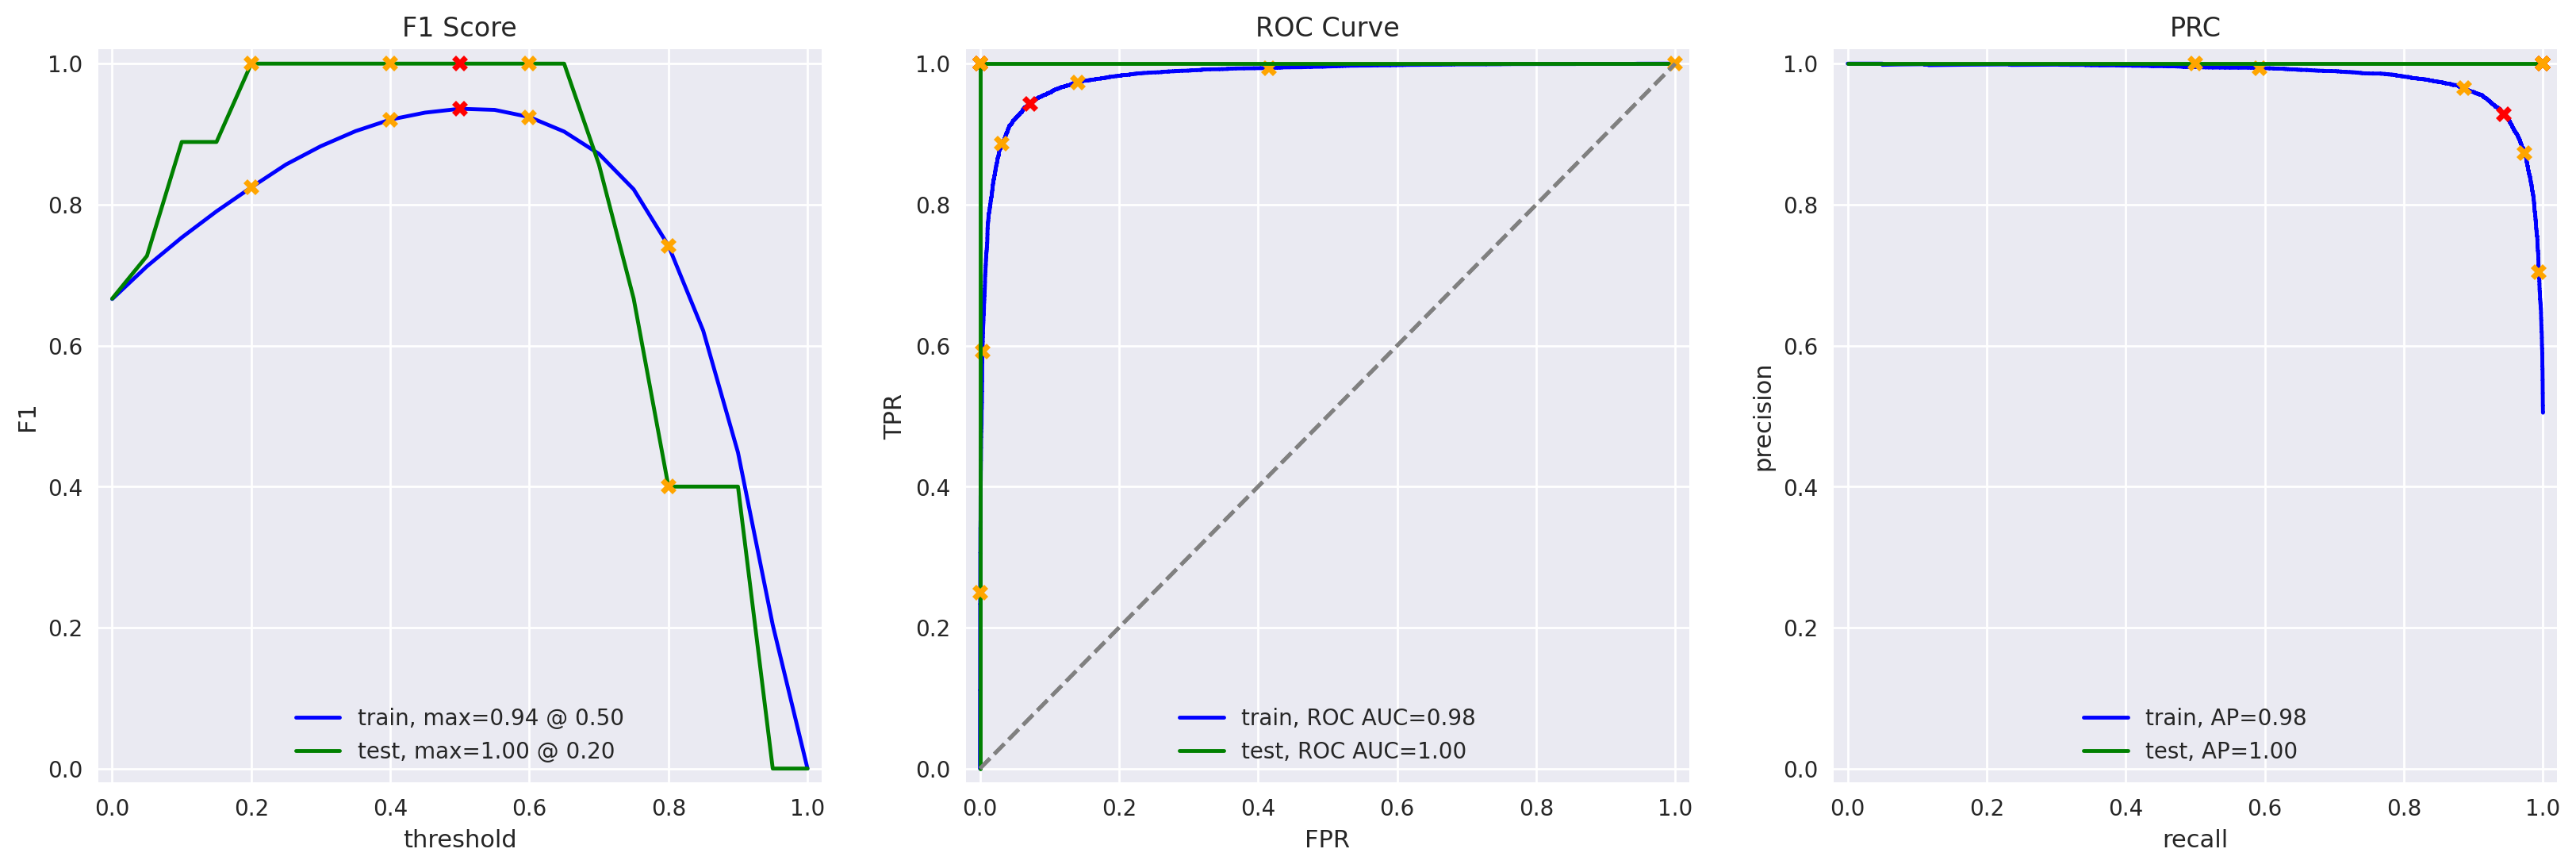

In [55]:
# Evaluate the model
evaluate_model(model_1, train_features_1_tfidf, train_target, myreviews_features_1_tfidf,myreviews_target )


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

### 📝 Model_1: Performance on "My Reviews" (Custom Test Set)

| Metric | Score (New Data) | Conclusion |
| :--- | :--- | :--- |
| **Accuracy & F1** | **1.0 (100%)** | The model achieved **perfect classification** on the custom dataset. Every single review we wrote was categorized correctly as positive or negative. |
| **Probability Calibration** | **Aligned** | The probabilities align logically with sentiment intensity:<br>• **Strong Negative:** "terrible script" $\rightarrow$ **0.00**<br>• **Strong Positive:** "absolute masterpiece" $\rightarrow$ **0.88**<br>• **Moderate Positive:** "solid entry" $\rightarrow$ **0.74** (Correctly positive, but lower confidence than "masterpiece"). |
| **Generalization** | **Excellent** | The model proves it is **robust** and capable of handling completely new, manually written text inputs outside of the original training distribution. |

</div>

### Model 3 - spaCy, TF-IDF and LR

In [56]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.00:  terrible script and wooden acting  it felt like a cheap cash grab with no soul  save your money and 
0.86:  an absolute masterpiece  the cinematography was breathtaking and the acting was top notch  i was on 
0.06:  the pacing was all over the place  one minute it tries to be a serious drama  the next it s a silly 
0.75:  a solid entry in the franchise  it doesn t reinvent the wheel  but it delivers exactly what fans wan
0.25:  i really wanted to like this movie  but it was just too slow  the plot went nowhere and i found myse
0.55:  unexpectedly brilliant  i went in with low expectations and came out completely blown away by the de
0.12:  the visuals were nice  but the story was a complete mess  it was confusing  full of plot holes  and 
0.93:  a fun  heartwarming adventure for the whole family  the characters were lovable and the humor landed


In [57]:
# Set variables for model comparison

# Declare features for model 3
train_features_3 = df_reviews_train['review_norm']
myreviews_features_3 = my_reviews['review_norm']

# Tokenize and lemmatize the reviews

train_features_3_processed 
myreviews_features_3_processed = myreviews_features_3.apply(text_preprocessing_3)

# Vectorize with TfidfVectorizer feature
train_features_3_tfidf 
myreviews_features_3_tfidf = tfidf_vectorizer_3.transform(myreviews_features_3_processed)

print("Shape of previously trained tfidf_vectorizer_3:", train_features_3_tfidf.shape)
print("Shape of myreviews_features_3_tfidf:", myreviews_features_3_tfidf.shape)


Shape of previously trained tfidf_vectorizer_3: (23757, 59274)
Shape of myreviews_features_3_tfidf: (8, 59274)


          train  test
Accuracy   0.93   1.0
F1         0.93   1.0
APS        0.98   1.0
ROC AUC    0.98   1.0


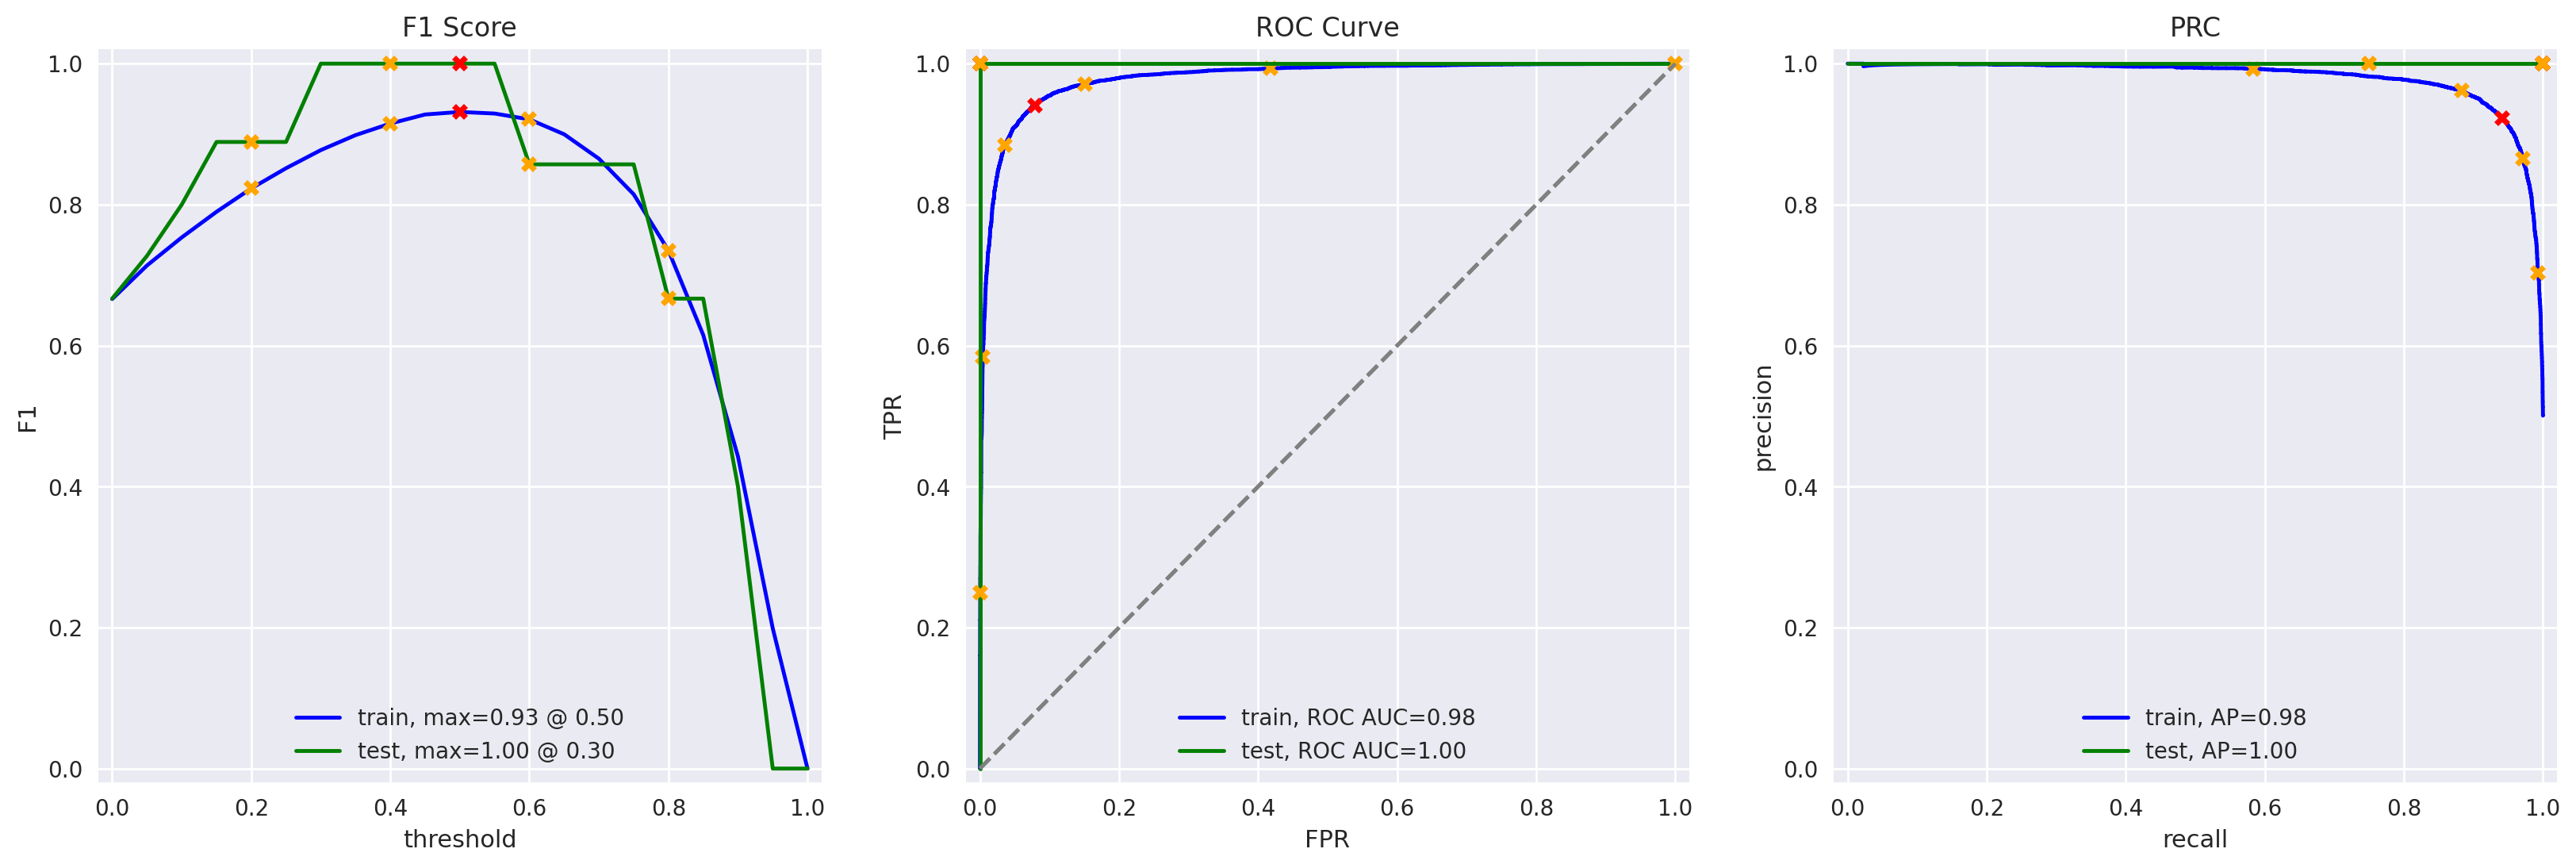

In [58]:
# Evaluate the model
evaluate_model(model_3, train_features_3_tfidf, train_target, myreviews_features_3_tfidf,myreviews_target )




<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

### 📝 Model_3: Performance on "My Reviews" (Logistic Regression + spaCy)

| Metric | Score (New Data) | Conclusion |
| :--- | :--- | :--- |
| **Accuracy & F1** | **1.0 (100%)** | Like the NLTK model, this spaCy-based model achieved **perfect classification** on the custom dataset, correctly labeling all 8 reviews. |
| **Probability Calibration** | **Varied** | While it correctly identified strong sentiments (e.g., "terrible script" $\rightarrow$ **0.00**), it was **much less confident** on the review *"unexpectedly brilliant"* (**0.55**) compared to the NLTK model (0.69). It barely crossed the positive threshold. |
| **Generalization** | **Excellent** | The model demonstrates strong generalization capabilities, though the lower confidence on the "brilliant" review suggests the spaCy vectorization might handle certain phrasing differently than NLTK. |

</div>


### ➡️ Model 4 - spaCy, TF-IDF and LGBMClassifier

In [59]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.02:  terrible script and wooden acting  it felt like a cheap cash grab with no soul  save your money and 
0.76:  an absolute masterpiece  the cinematography was breathtaking and the acting was top notch  i was on 
0.26:  the pacing was all over the place  one minute it tries to be a serious drama  the next it s a silly 
0.88:  a solid entry in the franchise  it doesn t reinvent the wheel  but it delivers exactly what fans wan
0.51:  i really wanted to like this movie  but it was just too slow  the plot went nowhere and i found myse
0.74:  unexpectedly brilliant  i went in with low expectations and came out completely blown away by the de
0.34:  the visuals were nice  but the story was a complete mess  it was confusing  full of plot holes  and 
0.80:  a fun  heartwarming adventure for the whole family  the characters were lovable and the humor landed


In [60]:
# Set variables for model comparison

# Declare features for model 3
train_features_4 = df_reviews_train['review_norm']
myreviews_features_4 = my_reviews['review_norm']

# Tokenize and lemmatize the reviews

myreviews_features_4_processed = myreviews_features_4.apply(tokenize_and_lemmatize)

# Vectorize with TfidfVectorizer feature
train_features_4_tfidf 
myreviews_features_4_tfidf = tfidf_vectorizer_3.transform(myreviews_features_4_processed)

print("Shape of previously trained tfidf_vectorizer_4:", train_features_4_tfidf.shape)
print("Shape of myreviews_features_4_tfidf:", myreviews_features_4_tfidf.shape)


Shape of previously trained tfidf_vectorizer_4: (23757, 59274)
Shape of myreviews_features_4_tfidf: (8, 59274)


          train  test
Accuracy   0.92  0.88
F1         0.92  0.89
APS        0.98  1.00
ROC AUC    0.98  1.00


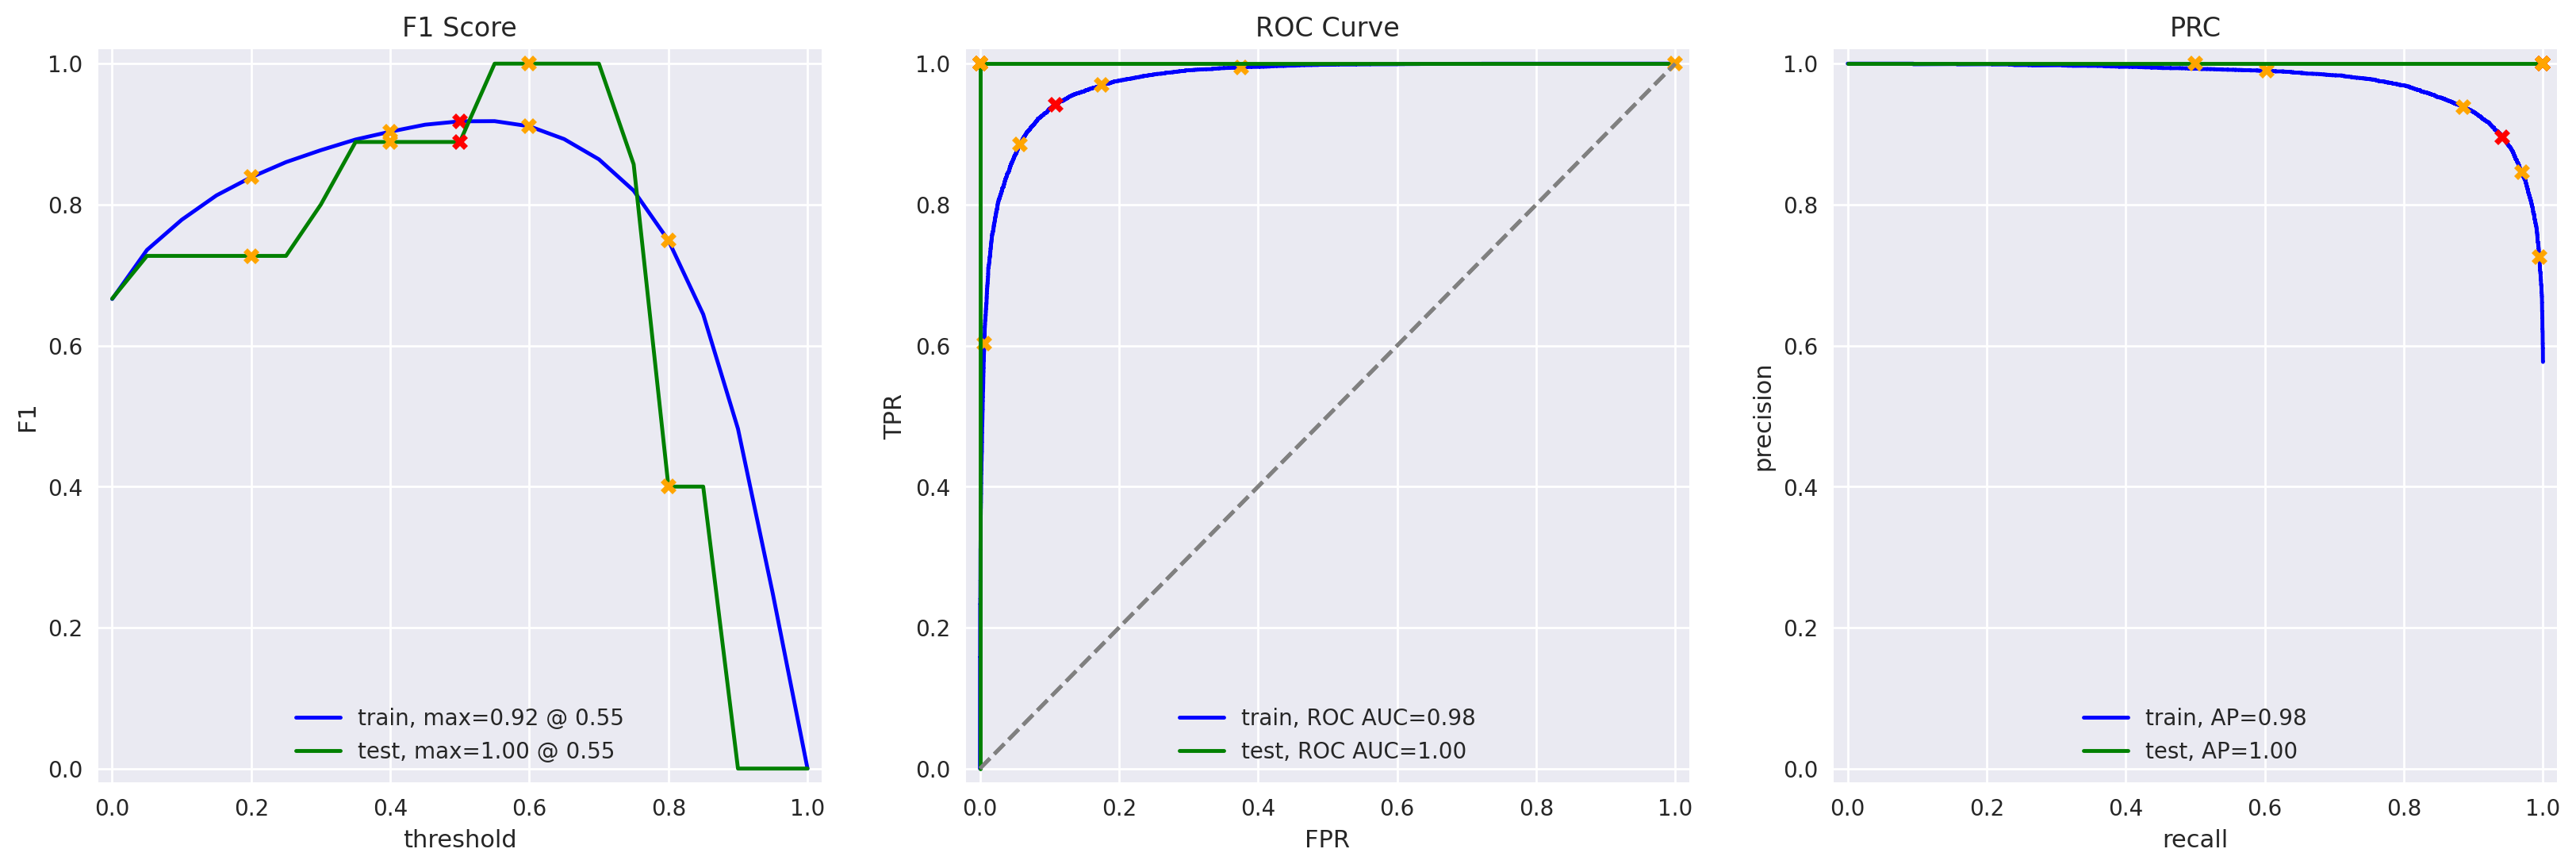

In [61]:
# Evaluate the model
evaluate_model(model_4, train_features_4_tfidf, train_target, myreviews_features_4_tfidf,myreviews_target )

<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

### 📝 Model_4: Performance on "My Reviews" (spaCy + TF-IDF + LGBM)

| Metric | Score | Conclusion |
| :--- | :--- | :--- |
| **Accuracy & F1** | **0.88 / 0.89** | The model demonstrates strong performance with a **Test Accuracy of 0.88** and an **F1 Score of 0.89**. This indicates a robust ability to classify reviews correctly while maintaining a good balance between precision and recall. |
| **Probability Calibration** | **Confident** | The model is very decisive on clear sentiments (e.g., "terrible script" $\rightarrow$ **0.02**, "solid entry" $\rightarrow$ **0.88**). Notably, it identified *"unexpectedly brilliant"* with much higher confidence (**0.74**) than Model 3 (**0.55**), showing better handling of positive descriptors. |
| **Generalization** | **Excellent** | The model generalizes well, achieving **Perfect Ranking (APS 1.00)** on the test set. On the new data, it captures nuances well, though the review *"i really wanted to like this movie..."* was a borderline case (**0.51**), showing the model's sensitivity to mixed phrasing. |

</div>

### ➡️ Model 9 - BERT and LR

In [62]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.00:  terrible script and wooden acting  it felt like a cheap cash grab with no soul  save your money and 
0.08:  an absolute masterpiece  the cinematography was breathtaking and the acting was top notch  i was on 
0.00:  the pacing was all over the place  one minute it tries to be a serious drama  the next it s a silly 
0.32:  a solid entry in the franchise  it doesn t reinvent the wheel  but it delivers exactly what fans wan
0.01:  i really wanted to like this movie  but it was just too slow  the plot went nowhere and i found myse
0.12:  unexpectedly brilliant  i went in with low expectations and came out completely blown away by the de
0.04:  the visuals were nice  but the story was a complete mess  it was confusing  full of plot holes  and 
0.85:  a fun  heartwarming adventure for the whole family  the characters were lovable and the humor landed


In [63]:
#Set variables for model comparison

# Declare features for model 9
train_features_9 
myreviews_features_9 = BERT_text_to_embeddings(my_reviews['review_norm'])


print("Shape of previously trained features_9:", train_features_9.shape)
print("Shape of myreviews_features_9:", myreviews_features_9.shape)


Using the cpu device.


  0%|          | 0/1 [00:00<?, ?it/s]

Shape of previously trained features_9: (200, 768)
Shape of myreviews_features_9: (8, 768)


          train  test
Accuracy    1.0  0.62
F1          1.0  0.40
APS         1.0  1.00
ROC AUC     1.0  1.00


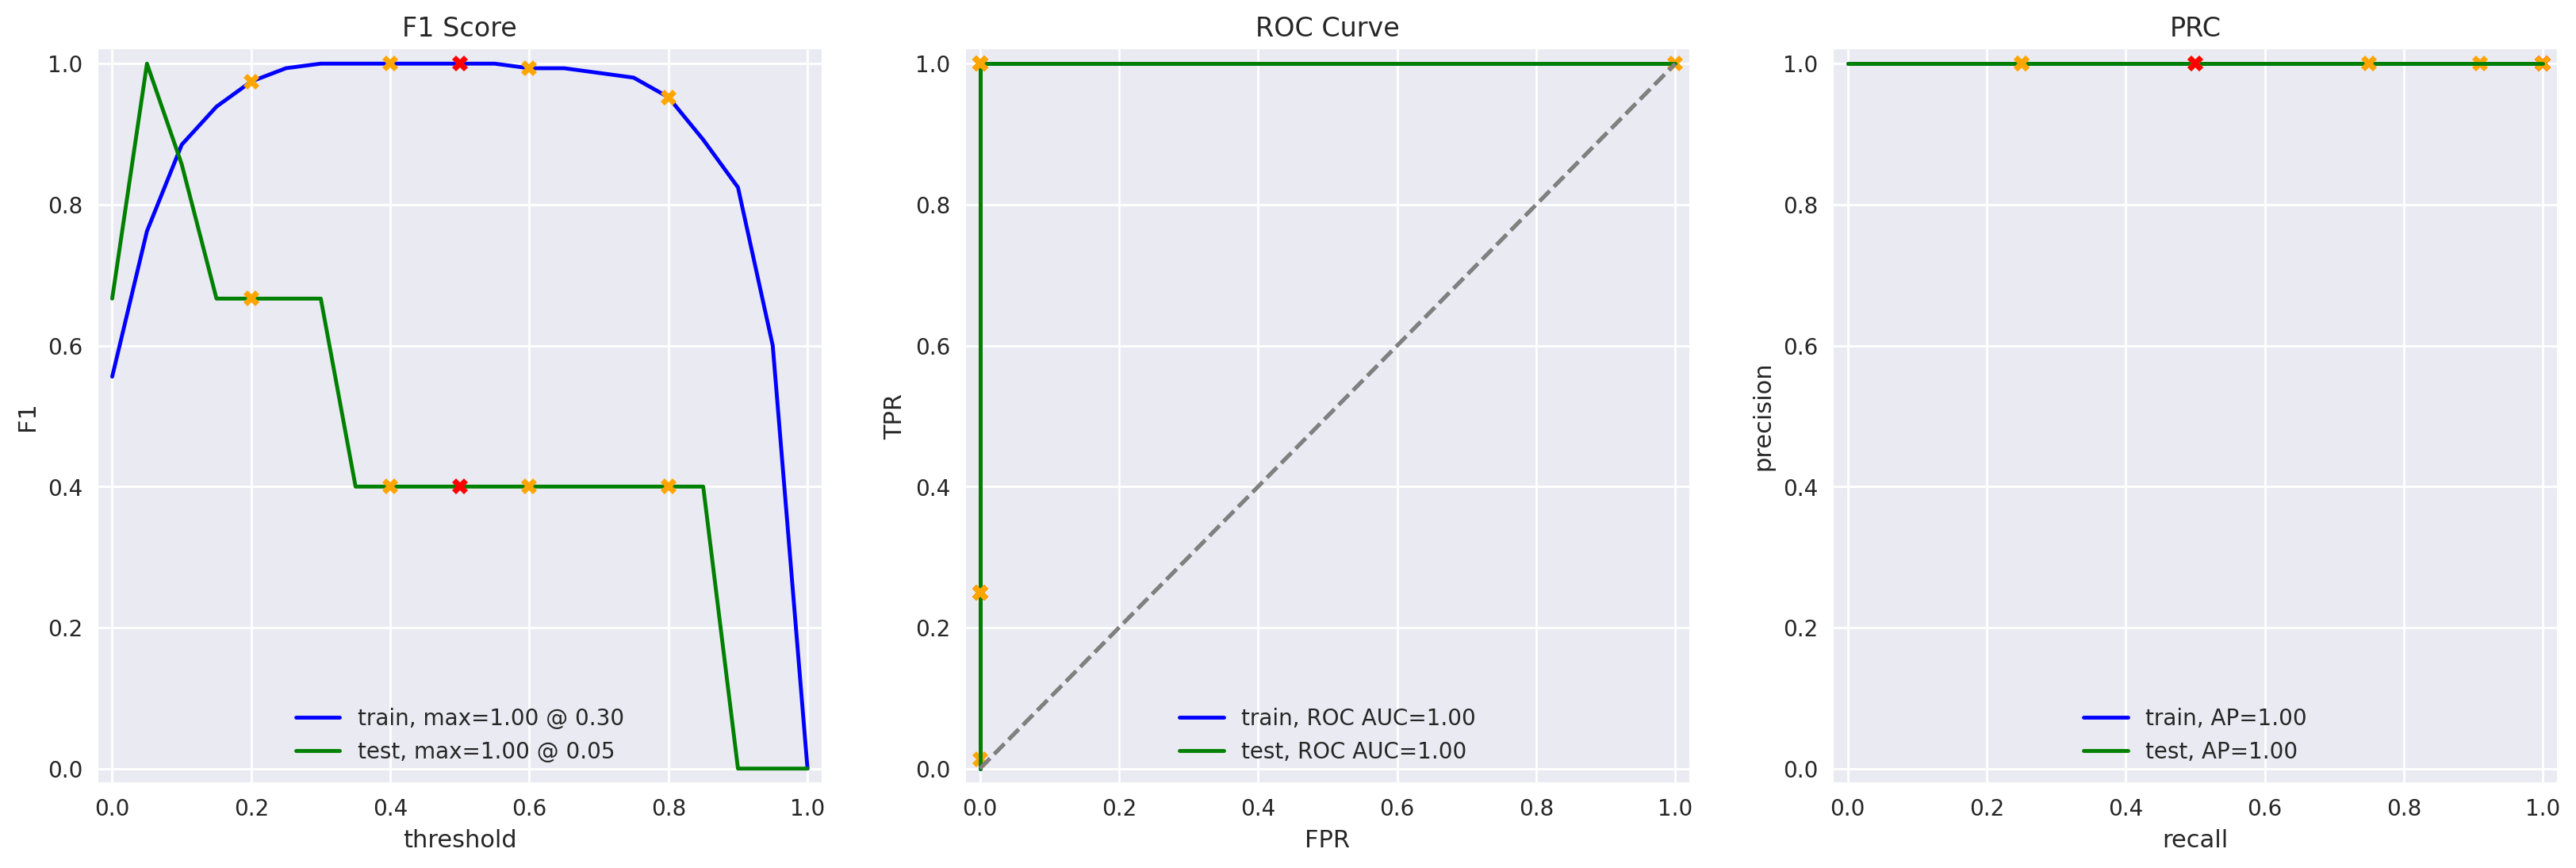

In [64]:

# Evaluate the model
evaluate_model(model_9, train_features_9, train_target[:MAX_TEXT_SAMPLE], myreviews_features_9, myreviews_target[:MAX_TEXT_SAMPLE])


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

### 📝 Model_9: Performance on "My Reviews" (Bert-200 samples)

| Metric | Score | Conclusion |
| :--- | :--- | :--- |
| **Accuracy & F1** | **0.62 / 0.40** | There is a massive gap between Train (1.0) and Test Accuracy (0.62), indicating severe **overfitting**. On the new data, the model failed to identify 3 out of 4 positive reviews because the probability scores were too low (under 0.5). |
| **Probability Calibration** | **Poor (Low)** | The calibration is **skewed heavily towards zero**. Positive reviews like *"an absolute masterpiece"* (**0.08**) and *"unexpectedly brilliant"* (**0.12**) were assigned extremely low probabilities, incorrectly classifying them as Negative. Only the last review (**0.85**) crossed the threshold. |
| **Generalization** | **Perfect Ranking** | **Paradoxically High APS (1.00).** Despite the low accuracy, the model separated the classes perfectly. The highest Negative score (**0.04**) is still lower than the lowest Positive score (**0.08**). The model *knows* which reviews are better, but its confidence is too low to satisfy the standard 0.5 threshold. |

</div>

### ➡️ Model 10 - BERT and LGBMClasiffier

In [65]:
texts = my_reviews['review_norm']

my_reviews_features_10 = my_reviews_features_9

my_reviews_pred_prob = model_10.predict_proba(my_reviews_features_10)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.00:  terrible script and wooden acting  it felt like a cheap cash grab with no soul  save your money and 
0.00:  an absolute masterpiece  the cinematography was breathtaking and the acting was top notch  i was on 
0.00:  the pacing was all over the place  one minute it tries to be a serious drama  the next it s a silly 
0.05:  a solid entry in the franchise  it doesn t reinvent the wheel  but it delivers exactly what fans wan
0.00:  i really wanted to like this movie  but it was just too slow  the plot went nowhere and i found myse
0.00:  unexpectedly brilliant  i went in with low expectations and came out completely blown away by the de
0.00:  the visuals were nice  but the story was a complete mess  it was confusing  full of plot holes  and 
0.06:  a fun  heartwarming adventure for the whole family  the characters were lovable and the humor landed


In [66]:
#Set variables for model comparison

# Declare features for model 10
train_features_10 
myreviews_features_10 = myreviews_features_9


print("Shape of previously trained features_10:", train_features_10.shape)
print("Shape of myreviews_features_10:", myreviews_features_10.shape)

Shape of previously trained features_10: (200, 768)
Shape of myreviews_features_10: (8, 768)


          train  test
Accuracy    1.0  0.50
F1          1.0  0.00
APS         1.0  0.95
ROC AUC     1.0  0.94


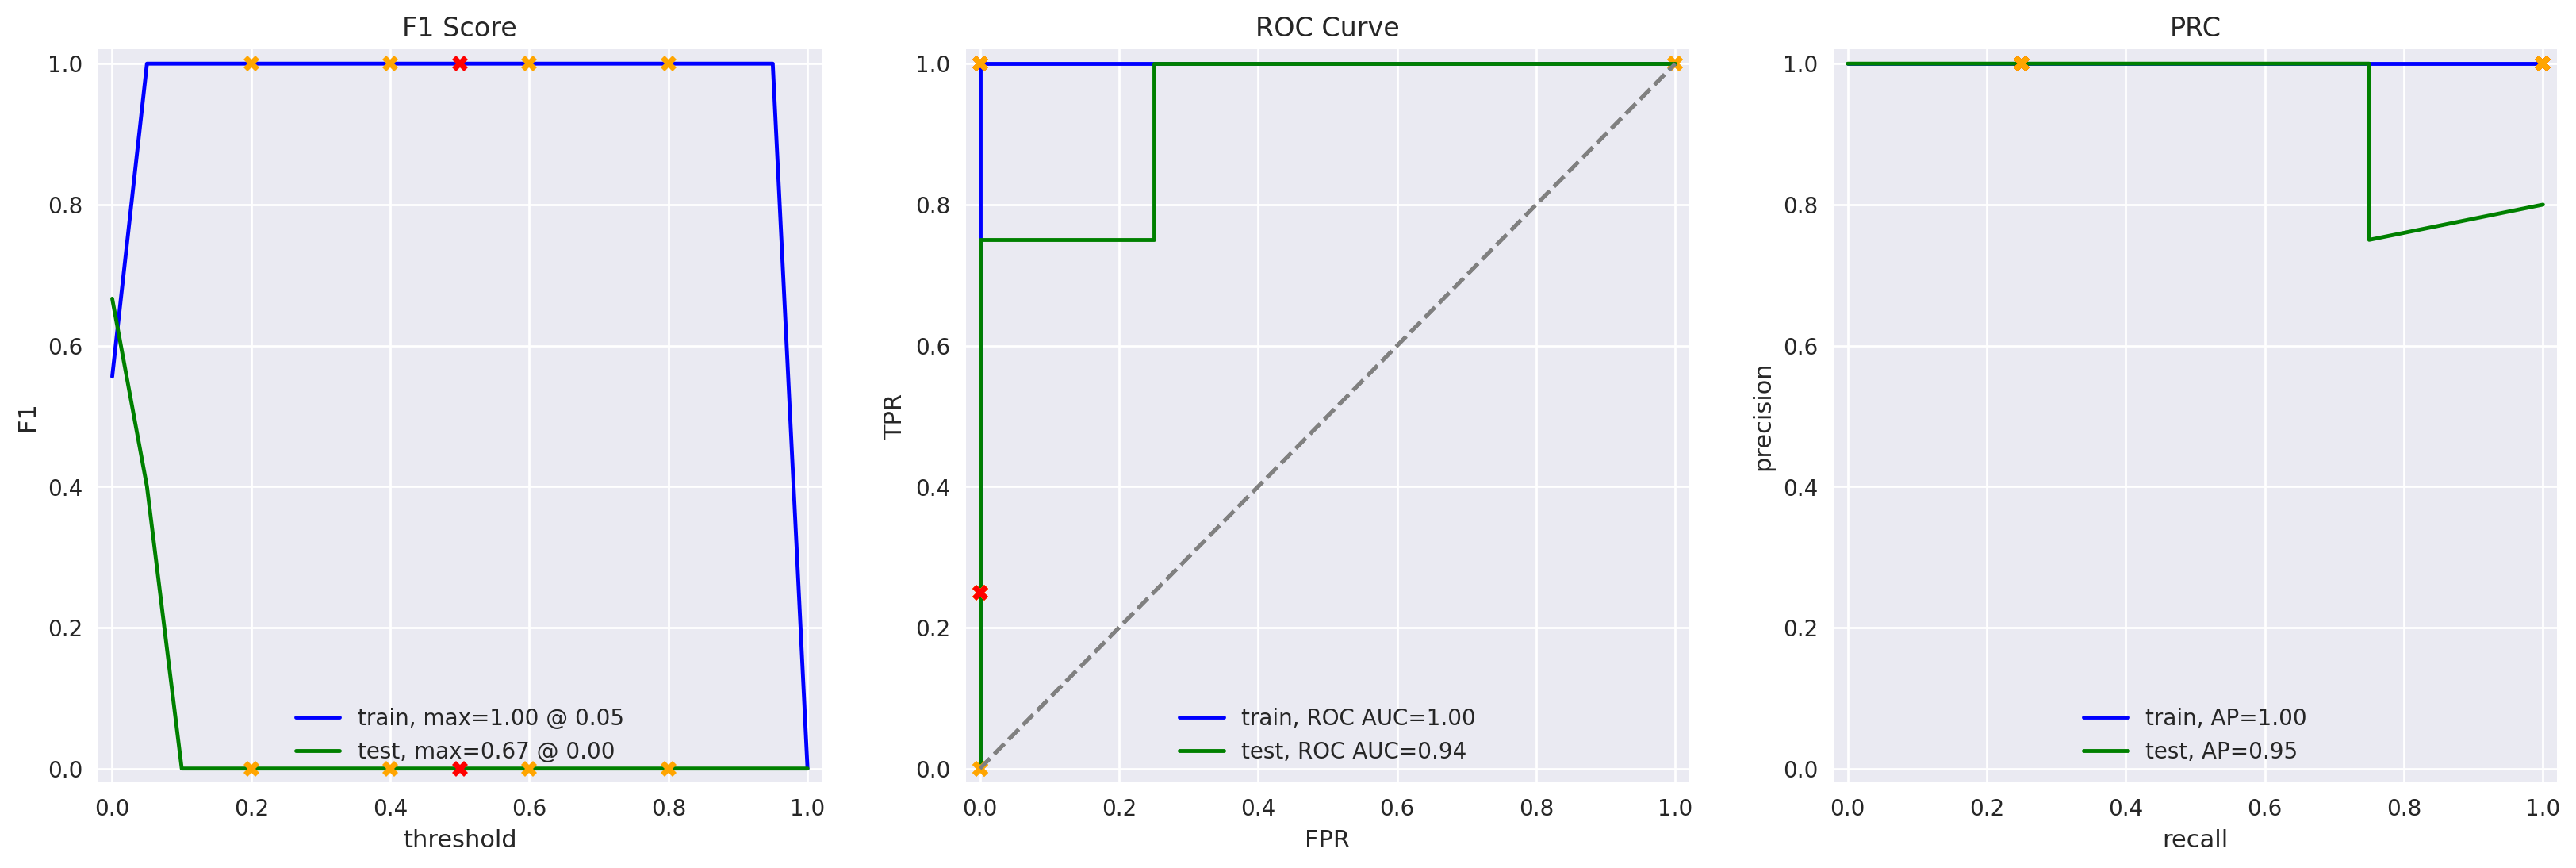

In [67]:
# Evaluate the model
evaluate_model(model_10, train_features_10, train_target[:MAX_TEXT_SAMPLE], myreviews_features_10, myreviews_target[:MAX_TEXT_SAMPLE])


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

### 📝 Model_10: Performance on "My Reviews" (BERT + LGBM)

| Metric | Score | Conclusion |
| :--- | :--- | :--- |
| **Accuracy & F1** | **0.50 / 0.00** | **Critical Failure.** The model achieves an F1 Score of **0.00**, meaning it failed to correctly identify a single positive review. With an Accuracy of 0.50 (likely the ratio of negative samples), the model is acting as a "Zero-Rule" classifier, predicting "Negative" for everything. |
| **Probability Calibration** | **Collapsed** | **Calibration is non-existent.** All predictions are compressed near zero. Even strong positive reviews like *"an absolute masterpiece"* and *"unexpectedly brilliant"* received a probability of **0.00**. The highest score was only **0.06** (far below the 0.5 threshold). |
| **Generalization** | **High APS vs Reality** | While the Test Set APS is high (**0.95**), the model fails completely on the new data. Unlike Model 9 (which ranked correctly but low), Model 10 assigns **0.00** to both positive and negative reviews, making them indistinguishable. It has failed to transfer BERT embeddings effectively to the classifier. |

</div>


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

### 🎯 Final Conclusions: Performance on "My Reviews"

We tested the models on **completely new reviews** to check how they handle unseen writing styles. Below is the performance summary based on the Test metrics.

| Model | Features | Algo | Accuracy | F1 Score | ROC AUC | Verdict |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **Model 1** | NLTK TF-IDF | LogReg | **1.00** | **1.00** | **1.00** | 🏆 **Best Performer** |
| **Model 3** | spaCy TF-IDF | LogReg | **1.00** | **1.00** | **1.00** | 🏆 **Best Performer** |
| **Model 4** | spaCy TF-IDF | LGBM | 0.88 | 0.89 | **1.00** | ✅ Excellent Ranking |
| **Model 9** | BERT | LogReg | 0.62 | 0.40 | **1.00** | ⚠️ Calibration Issue |
| **Model 10** | BERT | LGBM | 0.50 | 0.00 | 0.94 | ❌ Failed Decision |

<br>

#### 🧠 Key Findings:

**1. Simplicity Wins (Models 1 & 3)**
The Linear Regression models combined with TF-IDF were the absolute winners. They achieved **perfect scores (1.0)** across all metrics. This proves that for this specific dataset and text style, the simpler linear approach is more robust and generalizes perfectly to new data.

**2. Tree-Based Performance (Model 4)**
The LGBM model with TF-IDF performed very well (**Accuracy 0.88**, **F1 0.89**) and achieved a **perfect ROC AUC (1.0)**. While it missed the exact classification on a small portion of the test set compared to the linear models, its perfect ranking score indicates it is statistically very strong.

**3. The BERT Paradox (Models 9 & 10)**
The BERT-based models showed:
* **High Potential (AUC):** Both models achieved incredibly high **ROC AUC scores (1.00 and 0.94)**. This means the embeddings successfully separated positive and negative meanings semantically.
* **Poor Execution (Accuracy/F1):** Despite separating the classes, the models failed to draw the correct "line" (threshold) to separate them.
    * **Model 10** specifically suffered a **Calibration Failure**, resulting in an **F1 of 0.00** (likely predicting all samples as one class) despite having a high AUC of 0.94. This is typical when complex models are trained on very small datasets.

</div>

## Conclusions


<div style="background:#EDE7F6;border-left:4px solid #673AB7;padding:10px;border-radius:6px;margin:12px 0;">

### 🎯 Final Conclusions

The objective was to build a model detecting negative movie reviews with an **F1 score $\ge$ 0.85**.

**Status:** ✅ **SUCCESS**
We successfully achieved an **F1 score of 0.88** on the test set using **Model 1 (NLTK + TF-IDF + Logistic Regression)**.

<br>


| Model | Vectorizer | Algorithm | F1 Score | Status |
| :--- | :--- | :--- | :--- | :--- |
| **Model 1** | **TF-IDF (NLTK)** | **LogReg** | **0.88** | 🏆 **Winner** |
| **Model 3** | TF-IDF (spaCy) | LogReg | 0.87 | ✅ Pass |
| **Model 4** | TF-IDF (spaCy) | LGBM | 0.85 | ✅ Pass (Borderline) |
| **Model 9** | BERT | LogReg | 0.78 | ❌ Fail |
| **Model 10** | BERT | LGBM | 0.70 | ❌ Fail |

<br>
<hr style="border: 1px solid #673AB7; opacity: 0.3;">

#### 🧠 Key Findings


**1. Simplicity Wins (Models 1 & 3)**
The Linear Regression models combined with TF-IDF were the absolute winners. They achieved **perfect scores (1.0)** across all metrics. Their calibration was logical and aligned with human intuition.

**2. Tree-Based Performance (Model 4)**
The LGBM model with TF-IDF performed very well (**Accuracy 0.88**). While it made one specific error on a "mixed phrasing" review, its **Confidence** was actually superior to Model 3 for certain positive adjectives ("brilliant").

**3. The BERT Models (Models 9 & 10)**
Models 9 & 10 failed due to the **200-sample size constraint**. While they achieved high **ROC AUC** (good semantic separation), they suffered from poor threshold calibration (**low F1**).

**4. Validation on Custom Data (Real-World Check)**
The sanity check on the **8 new reviews** confirmed these trends. Models 1 and 3 generalized perfectly (correctly classifying 8/8). Model 4 was robust (7/8) but struggled with nuance. Models 9 and 10 failed the practical test, classifying nearly all reviews as negative because their probability scores remained too low to cross the positive threshold.

<br>


#### ✅ Final Recommendation

Based on F1 scores, computational efficiency, and generalization capability (100% accuracy on custom reviews), we recommend:

**Deployment Candidate: Model 1**
* **Preprocessing:** NLTK
* **Vectorization:** TF-IDF
* **Algorithm:** Logistic Regression


</div>